In [ ]:
!pip install demoji

     |████████████████████████████████| 42 kB 642 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import spacy
import csv
import re
import string
#import demoji
import html
from nltk.tokenize import word_tokenize

In [ ]:
#replace these paths with your paths
path = "/content/drive/My Drive/PluriTAL/Projet Annotations/"
path_to_stop_words = path + "stoplist.txt"
path_to_uk_words = path + "uk_words.txt"
path_to_us_words = path + "american_words.txt"
path_to_data = "df_all_accents_176535_v2.1"

In [ ]:
from google.colab import files, drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data and Resources

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open(path_to_data).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

In [ ]:
# prétraitements : Nettoyage du corpus. On enlève le bruit + les stopwords, mais pas de lemmatisation. 
#df = pd.read_csv('df_all_accents_US_updated') # ouvrir le fichier dans un dataframe
df = pd.DataFrame.from_records(rows, columns = ['user', 'id', 'text', 'region'])

In [ ]:
stop_words_file = open(path_to_stop_words, "r")
stop_words = stop_words_file.readlines()
stop_words = set([x.replace("\n","") for x in stop_words])

In [ ]:
uk_words_file = open(path_to_uk_words, "r")
uk_words = uk_words_file.readlines()
uk_words = set([x.replace("\n","") for x in uk_words])

In [ ]:
us_words_file = open(path_to_us_words, "r")
us_words = us_words_file.readlines()
us_words = set([x.replace("\n","") for x in us_words])

In [ ]:
#add cells from Yagmur
regions = ["UK", "US", "Canada", "Australia"]
for region in regions:
  print (region, df[df["region"]==region].shape[0])

UK 41910
US 50486
Canada 48695
Australia 35444


# Preprocessing

In [ ]:
def process_emojis(text, level):
    #KK: why not replace them with descriptions
    #text = demoji.replace_with_desc(text)
    if (level == 0):
        return text
    elif (level == 1):
        emoji = demoji.findall(text)
        for i in emoji.keys():
            text = text.replace(i,"")
    elif (level == 2):
        text = demoji.replace_with_desc(text, sep="")
    elif (level == 3):
        text = demoji.replace_with_desc(text, sep=":")
    else:
        print ('Level not supported: ', level)
    return text

def process_hashtags(text, level):
    if (level == 0):
        return text
    elif (level == 1):
        return re.sub(r"\#","",text)
    elif (level == 2):
        return re.sub(r"\#\w*","",text)
    else:
        print ('Level not supported: ', level)

def process_tags(text, level):
    if (level == 0):
        return text
    elif (level == 1):
        return re.sub(r"@","",text)
    elif (level == 2):
        return re.sub(r"(?<=\s)@\w*","",text)
    else:
        print ('Level not supported: ', level)

def process_punctuation(text, level):
    if (level == 0):
        return re.sub(r"\s+"," ",text)
    elif (level == 1):
        text = re.sub(r"[&%!?\|\"{\(\[|_\)\]},;/:§»«”“‘…–—−+’><]"," ",text)
        text = re.sub(r"\.\s"," ",text)
        text = text.replace(u'\xa0', u' ') # Supprimer espace 
        text = text.replace('\u2060', ' ') # Supprimer séparateur invisible
        text = text.replace("\u200d🎓", "") # Bruit unicode
        text = text.replace("\u2063", "")
        return re.sub(r"\s+"," ",text)
    else:
        print ('Level not supported: ', level)

def process_num(text, level):
    if (level == 0):
        return text
    elif (level == 1):
        text = re.sub(r"\d+([.,]\d+)?","",text) 
        return text
    elif (level == 2):
        return re.sub(r"\d+([.,]\d+)?","NUM",text)
    elif (level == 3):
        return re.sub(r"\d+([.,]\d+)?",":NUM:",text)
    else:
        print ('Level not supported: ', level)

In [ ]:
def pretraitement(text, 
                  process_hashtags_level=2, 
                  process_tags_level=2, 
                  process_emojis_level=2, 
                  process_punctuation_level=1,
                  process_num_level=2,
                  tokenize=1,
                  lemmatize=0,
                  prepr=spacy.load('en')):
    #process_hashtags: 
    ## 1: text #hashtag -> text
    ## 2: text #hashtag -> text hashtag
    ## 0: text #hashtag -> text #hashtag

    #process_tags: 
    ## 1: text @tag -> text
    ## 2: text @tag -> text tag
    ## 0: text @tag -> text @tag

    #process_emojis: 
    ## 1: text ✨ -> text
    ## 2: text ✨ -> text sparkles
    ## 3: text ✨ -> text :sparkles:
    ## 0: text ✨ -> text ✨

    #process_num: 
    ## 1: text 10 -> text
    ## 2: text 10 -> text NUM
    ## 3: text 10 -> text :NUM:
    ## 0: text 10 -> text 10

    #process_punctuation: 
    ## 1: text! -> text
    ## 0: text! -> text !

    text = html.unescape(text)
   # text = text.lower()

    text = process_emojis(text, process_emojis_level)
    text = process_hashtags(text, process_hashtags_level)
    text = process_tags(text, process_tags_level)
    text = process_num(text, process_num_level)
    text = process_punctuation(text, process_punctuation_level)
    if tokenize and lemmatize:
        return [token.lemma_ for token in prepr(text)]
    elif tokenize:
        return text.split(" ")
    else:
        return text

In [ ]:
pretraitement('i luv ✨ &lt;&lt;u &gt; 2 @Mary! #friends #best_friends', 
                  process_hashtags_level=1, 
                  process_tags_level=1, 
                  process_emojis_level=1, 
                  process_punctuation_level=1,
                  process_num_level=1)

['i', 'luv', 'u', 'Mary', 'friends', 'best', 'friends']

In [ ]:
def pretraitement_lem(x):
  return pretraitement(x, lemmatize=1)

In [ ]:
%%time
from multiprocessing import Pool
from tqdm.notebook import tqdm 
if __name__ == '__main__':
    p=Pool(processes = 4) #CPU count
    df['tokens_prepr_lem'] = p.map(pretraitement_lem, tqdm(df.text))
    df['tokens_prepr'] = p.map(pretraitement, tqdm(df.text))

  0%|          | 0/176536 [00:00<?, ?it/s]

  0%|          | 0/176536 [00:00<?, ?it/s]

CPU times: user 11.5 s, sys: 2.16 s, total: 13.7 s
Wall time: 26min 9s


In [ ]:
df.head()

,user,id,text,region,tokens_prepr_lem,tokens_prepr
0,user,id,text,region,[text],[text]
1,EmmaWatson,1449353227145818112,Join me and please sign &gt;&gt;Petition Link ...,UK,"[join, -PRON-, and, please, sign, Petition, Li...","[Join, me, and, please, sign, Petition, Link, ..."
2,EmmaWatson,1394399823898431488,"I am sending so much love to you, hoping you’r...",UK,"[-PRON-, be, send, so, much, love, to, -PRON-,...","[I, am, sending, so, much, love, to, you, hopi..."
3,EmmaWatson,1394399765001998338,In the mean time please assume no news from me...,UK,"[in, the, mean, time, please, assume, no, news...","[In, the, mean, time, please, assume, no, news..."
4,EmmaWatson,1394399590061805574,If I have news - I promise I’ll share it with ...,UK,"[if, -PRON-, have, news, -, -PRON-, promise, -...","[If, I, have, news, -, I, promise, I, ll, shar..."


In [ ]:
df.to_pickle(path+'twitter_prepr2_lemm.pkl')

In [ ]:
df = pd.read_pickle(path+'twitter_prepr2_lemm.pkl')

In [ ]:
df = df[1:]
df.head()

,user,id,text,region,tokens_prepr_lem,tokens_prepr
1,EmmaWatson,1449353227145818112,Join me and please sign &gt;&gt;Petition Link ...,UK,"[join, -PRON-, and, please, sign, Petition, Li...","[Join, me, and, please, sign, Petition, Link, ..."
2,EmmaWatson,1394399823898431488,"I am sending so much love to you, hoping you’r...",UK,"[-PRON-, be, send, so, much, love, to, -PRON-,...","[I, am, sending, so, much, love, to, you, hopi..."
3,EmmaWatson,1394399765001998338,In the mean time please assume no news from me...,UK,"[in, the, mean, time, please, assume, no, news...","[In, the, mean, time, please, assume, no, news..."
4,EmmaWatson,1394399590061805574,If I have news - I promise I’ll share it with ...,UK,"[if, -PRON-, have, news, -, -PRON-, promise, -...","[If, I, have, news, -, I, promise, I, ll, shar..."
5,EmmaWatson,1394399258451734528,"Dear Fans, \nRumours about whether I’m engaged...",UK,"[dear, fan, rumour, about, whether, -PRON-, m,...","[Dear, Fans, Rumours, about, whether, I, m, en..."


In [ ]:
type(df['tokens_prepr_lem'][1][0])

str

# Learn vector models

In [ ]:
#%%time
#modèle doc2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
all_processed_tweets = df['tokens_prepr']
documents = [TaggedDocument(doc,[i]) for i, doc in enumerate(all_processed_tweets)] # Donne à chauqe document un indice
# train model
model_doc2vec = Doc2Vec(documents, min_count=1)
# loaded model
model_doc2vec.save(path+"doc2vec_model22.bin") # création du modèle en format binaire 
 #Test 
#model_doc2vec_saved = Doc2Vec.load(path+"doc2vec_model22.bin")
#print(model_doc2vec.infer_vector(["king","awaits","session","tomorrow"]))# random words
#print(model_doc2vec_saved.infer_vector(["king","awaits","session","tomorrow"]))# random words

In [ ]:
#%%time
#modèle doc2vec sur la partie lemmatisée 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
all_processed_tweets = df['tokens_prepr_lem']
documents_lem = [TaggedDocument(doc,[i]) for i, doc in enumerate(all_processed_tweets)] # Donne à chauqe document un indice
# train model
model_doc2vec_lem = Doc2Vec(documents, min_count=1)
# loaded model
model_doc2vec_lem.save(path+"doc2vec_model22_lem.bin") # création du modèle en format binaire 
 #Test 
#model_doc2vec_saved_lem = Doc2Vec.load(path+"doc2vec_model2_lem.bin")
#print(model_doc2vec_lem.infer_vector(["king","awaits","session","tomorrow"]))# random words
#print(model_doc2vec_saved_lem.infer_vector(["king","awaits","session","tomorrow"]))# random words

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
all_processed_tweets = df['tokens_prepr']
# train model
model = Word2Vec(all_processed_tweets, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary -- this didn't work for me
# access vector for one word
print(model.wv)
# save model
model.save(path+'word2vec_model22.bin') # création du modèle en format binaire. 

Word2Vec(vocab=251798, size=100, alpha=0.025)


In [ ]:
from gensim.models import Word2Vec, KeyedVectors
all_processed_tweets = df['tokens_prepr_lem']
# train model
#model_lem = Word2Vec(all_processed_tweets)
model_lem = Word2Vec(min_count=1)
model_lem.build_vocab(all_processed_tweets)  # prepare the model vocabulary
model_lem.train(all_processed_tweets, total_examples=len(all_processed_tweets), epochs=model.epochs)
# summarize the loaded model
print(model_lem)
# summarize vocabulary -- this didn't work for me
# access vector for one word
print(model_lem.wv)
# save model
model_lem.save(path+'word2vec_model22_lem.bin') # création du modèle en format binaire. 

Word2Vec(vocab=216778, size=100, alpha=0.025)


# Vectorize with learnt models

In [ ]:
#from numpy.core.numeric import zeros_like
def get_w2v_for_word(model, word):
  try:
    vec = model.wv[word]
  except Exception as e:
    vec = np.zeros(model.wv.vector_size)
  return vec

In [ ]:
def mean_vec_for_phrase(model, words):
    a = [np.zeros(model.wv.vector_size)]
    for word in words:
      a.append(get_w2v_for_word(model, word.lower()))
    return np.mean(a, axis=0)

In [ ]:
def check_in_uk_list(word_list):
    return len(set(word_list).intersection(uk_words))
def check_in_us_list(word_list):
    return len(set(word_list).intersection(us_words))

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
model_doc2vec_saved = Doc2Vec.load(path+"doc2vec_model22.bin")
model_word2vec_saved = KeyedVectors.load(path+"word2vec_model22.bin")
model_doc2vec_saved_lem = Doc2Vec.load(path+"doc2vec_model22_lem.bin")
model_word2vec_saved_lem = KeyedVectors.load(path+"word2vec_model22_lem.bin")
def vectorize_doc2vec(x, model=model_doc2vec_saved):
    return np.append(model.infer_vector(x), [check_in_uk_list(x), check_in_us_list(x)])
def vectorize_doc2vec_lem(x, model=model_doc2vec_saved_lem):
    return np.append(model.infer_vector(x), [check_in_uk_list(x), check_in_us_list(x)])

def vectorize_word2vec(x, model=model_word2vec_saved):
    return np.append(mean_vec_for_phrase(model, x), [check_in_uk_list(x), check_in_us_list(x)])
def vectorize_word2vec_lem(x, model=model_word2vec_saved_lem):
    return np.append(mean_vec_for_phrase(model, x), [check_in_uk_list(x), check_in_us_list(x)])

In [ ]:
%%time
from multiprocessing import Pool
from tqdm.notebook import tqdm 
if __name__ == '__main__':
    p=Pool(processes = 4) #CPU count
    df['word2vec_vector_lem'] = p.map(vectorize_word2vec_lem, tqdm(df.tokens_prepr_lem))
    df['doc2vec_vector'] = p.map(vectorize_doc2vec, tqdm(df.tokens_prepr))
    df['doc2vec_vector_lem'] = p.map(vectorize_doc2vec_lem, tqdm(df.tokens_prepr_lem))
    df['word2vec_vector'] = p.map(vectorize_word2vec, tqdm(df.tokens_prepr))

  0%|          | 0/176535 [00:00<?, ?it/s]

  0%|          | 0/176535 [00:00<?, ?it/s]

  0%|          | 0/176535 [00:00<?, ?it/s]

  0%|          | 0/176535 [00:00<?, ?it/s]

CPU times: user 11.2 s, sys: 2.69 s, total: 13.8 s
Wall time: 4min 3s


In [ ]:
df.head()

,user,id,text,region,tokens_prepr_lem,tokens_prepr,word2vec_vector_lem,doc2vec_vector,doc2vec_vector_lem,word2vec_vector
1,EmmaWatson,1449353227145818112,Join me and please sign &gt;&gt;Petition Link ...,UK,"[join, -PRON-, and, please, sign, Petition, Li...","[Join, me, and, please, sign, Petition, Link, ...","[-0.1633692979812622, 0.06693916129214424, 0.0...","[-0.003262137994170189, 0.027542011812329292, ...","[0.0018406962044537067, -0.009951082058250904,...","[0.07911569997668266, -0.33699789217540194, -0..."
2,EmmaWatson,1394399823898431488,"I am sending so much love to you, hoping you’r...",UK,"[-PRON-, be, send, so, much, love, to, -PRON-,...","[I, am, sending, so, much, love, to, you, hopi...","[-1.9933871592200079, 2.1453694711590923, 0.27...","[-0.014545850455760956, 0.03204139322042465, -...","[0.006240102928131819, -0.011766741052269936, ...","[-1.1976196050297383, 0.4413713983978892, 0.62..."
3,EmmaWatson,1394399765001998338,In the mean time please assume no news from me...,UK,"[in, the, mean, time, please, assume, no, news...","[In, the, mean, time, please, assume, no, news...","[-2.132112238591967, 1.756576634495734, 0.3601...","[-0.0627424567937851, 0.014601125381886959, -0...","[-0.08060629665851593, 0.05810973793268204, -0...","[-0.238004554647441, 0.6014402696244218, 0.832..."
4,EmmaWatson,1394399590061805574,If I have news - I promise I’ll share it with ...,UK,"[if, -PRON-, have, news, -, -PRON-, promise, -...","[If, I, have, news, -, I, promise, I, ll, shar...","[-1.4156966129938762, 1.1194852272669473, 0.40...","[-0.017142683267593384, -0.0190928615629673, 0...","[-0.023666521534323692, -0.007497739978134632,...","[-0.9642263693468911, 0.17201397255329148, -0...."
5,EmmaWatson,1394399258451734528,"Dear Fans, \nRumours about whether I’m engaged...",UK,"[dear, fan, rumour, about, whether, -PRON-, m,...","[Dear, Fans, Rumours, about, whether, I, m, en...","[-1.7273636009411089, 1.301241026353091, 0.136...","[-0.022522781044244766, -0.0023008864372968674...","[-0.0190250426530838, 0.11098308861255646, -0....","[-0.3278396710863008, 0.7478080059209948, 0.61..."


In [ ]:
df.to_pickle(path+'twitter_prepr2_lem_vectorized.pkl')

# Load Vectorized Data and Classify

In [ ]:
import pandas as pd
df = pd.read_pickle(path+'twitter_prepr2_lem_vectorized.pkl')
#df[df.word2vec_vector_lem.apply(len) == 3]

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes, svm 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
def classify(regions, classifier, vector, test_size = 0.4):
  X_train, X_test, y_train, y_test = train_test_split(df[df['region'].isin(regions)][vector], 
                                                      df[df['region'].isin(regions)].region, 
                                                      test_size = test_size, shuffle=True)
  X_train = np.stack(X_train.values)
  X_test = np.stack(X_test.values)
  classifier.fit(X_train, y_train)
  y_predicted = classifier.predict(X_test)
  accuracy = classifier.score(X_test, y_test)
  res = pd.DataFrame(list(zip(y_predicted, y_test, X_test)), columns=['predicted_region', 'expected_region', 'text'])
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize = (10, 7))
  sn.heatmap(cm, annot=True, fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  print ('Accuracy: ' + str(accuracy))
  return accuracy, res, cm

In [ ]:
def test_different_classifiers(regions, vector, test_size = 0.4):
  #classifiers = (logreg_cl, knn_cl, svm_cl, nbm_cl) = (LogisticRegression(max_iter=30000), KNeighborsClassifier(), svm.SVC(), naive_bayes.MultinomialNB())
  #classifiers = (rf_cl, logreg_cl, knn_cl, svm_cl) = (RandomForestClassifier(), LogisticRegression(max_iter=30000), KNeighborsClassifier(), svm.SVC())
  classifiers = (rf_cl, logreg_cl, knn_cl, svm_cl) = (RandomForestClassifier(), LogisticRegression(max_iter=30000), KNeighborsClassifier(), svm.LinearSVC())
  
  for classifier in classifiers:
    print (classifier)
    classify(regions, classifier, vector, test_size)

In [ ]:
def test_different_vectors_and_classifiers(regions, test_size = 0.4):
  for vector in ['word2vec_vector_lem', 'word2vec_vector', 'doc2vec_vector_lem', 'doc2vec_vector']:
    print ('\n**************************\nVector Space: %s\nClassifiers:' % vector)
    test_different_classifiers(regions, vector, test_size)

## Tests

Accuracy: 0.6775345653291485


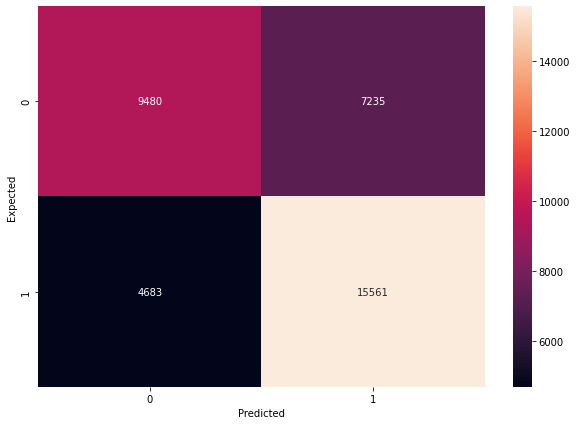

In [ ]:
logreg_cl = LogisticRegression(max_iter=30000)
logreg_accuracy, logreg_res, logreg_cm = classify(['US', 'UK'], logreg_cl, 'doc2vec_vector_lem')

Accuracy: 0.6043182986552667


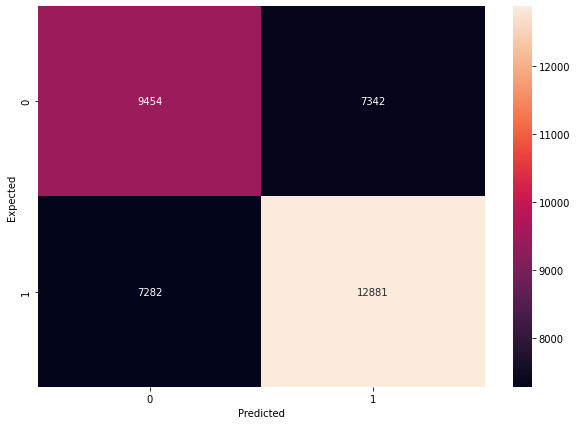

In [ ]:
knn_cl = KNeighborsClassifier()
knn_accuracy, knn_res, knn_cm = classify(['US', 'UK'], knn_cl, 'doc2vec_vector_lem') 

Accuracy: 0.33579743393661315


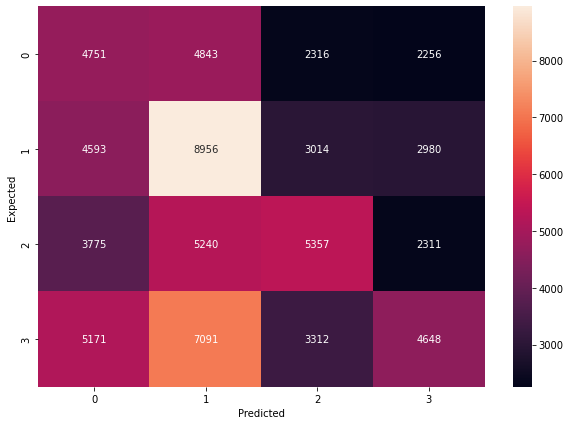

In [ ]:
knn_cl2 = KNeighborsClassifier()
knn_accuracy2, knn_res2, knn_cm2 = classify(['US', 'UK', 'Australia', 'Canada'], knn_cl2, 'doc2vec_vector_lem') 


**************************
Vector Space: word2vec_vector_lem
Classifiers:
LogisticRegression(max_iter=30000)
Accuracy: 0.6486647366000162
KNeighborsClassifier()
Accuracy: 0.6346762628859006
SVC()
Accuracy: 0.6792662139127141

**************************
Vector Space: word2vec_vector
Classifiers:
LogisticRegression(max_iter=30000)
Accuracy: 0.6526962309586298
KNeighborsClassifier()
Accuracy: 0.6290754619984307
SVC()
Accuracy: 0.6745582943261452

**************************
Vector Space: doc2vec_vector_lem
Classifiers:
LogisticRegression(max_iter=30000)
Accuracy: 0.6744230092805541
KNeighborsClassifier()
Accuracy: 0.6057793771476501
SVC()
Accuracy: 0.699288400660191

**************************
Vector Space: doc2vec_vector
Classifiers:
LogisticRegression(max_iter=30000)
Accuracy: 0.6879244568305419
KNeighborsClassifier()
Accuracy: 0.6141129359560594
SVC()
Accuracy: 0.7097053491707027


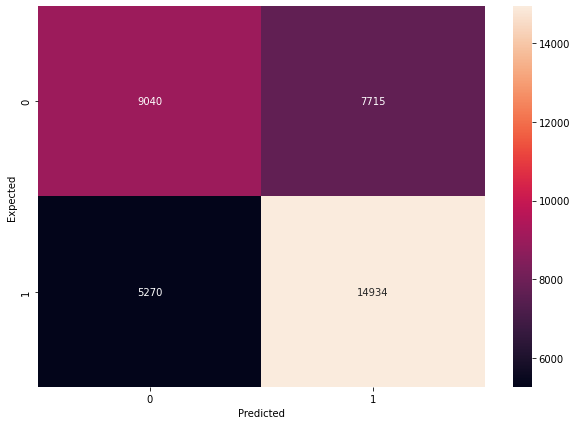

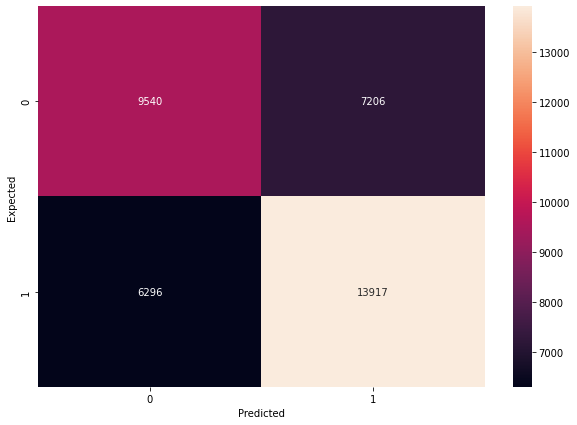

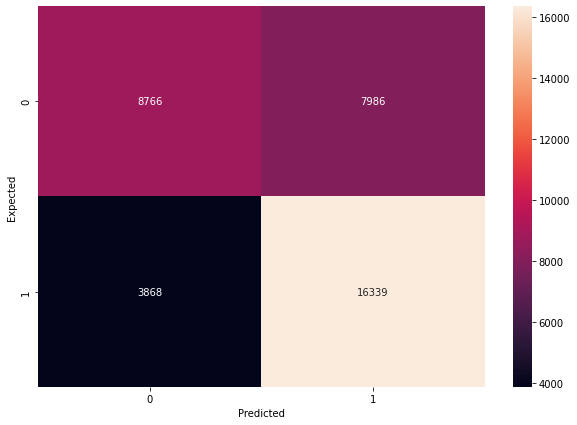

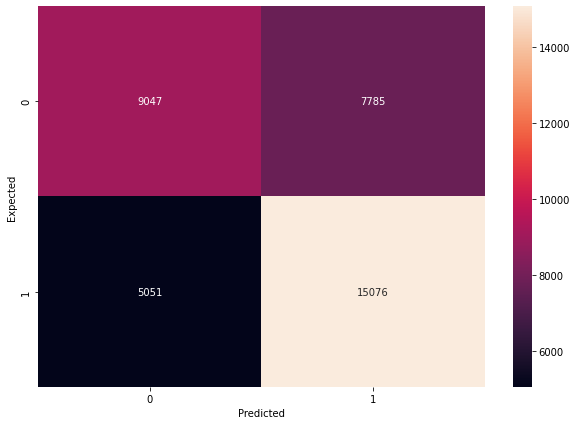

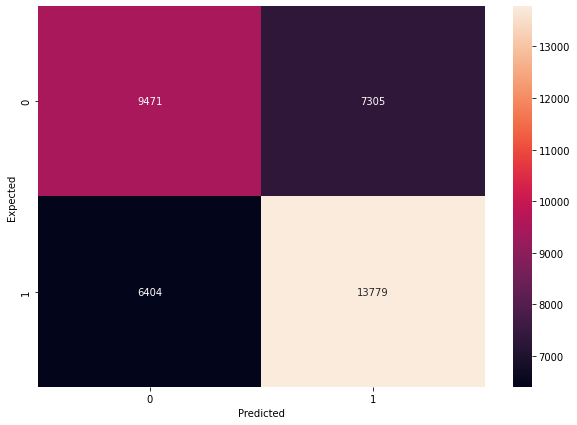

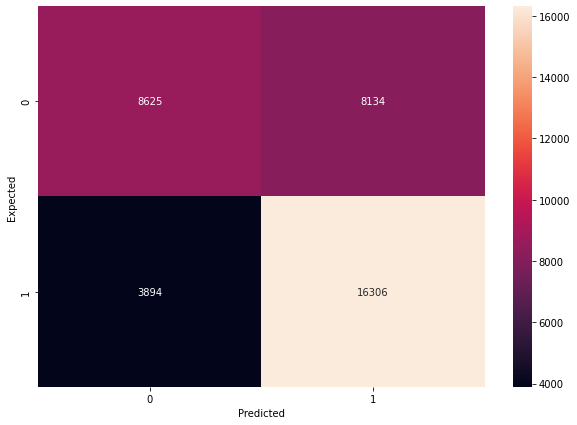

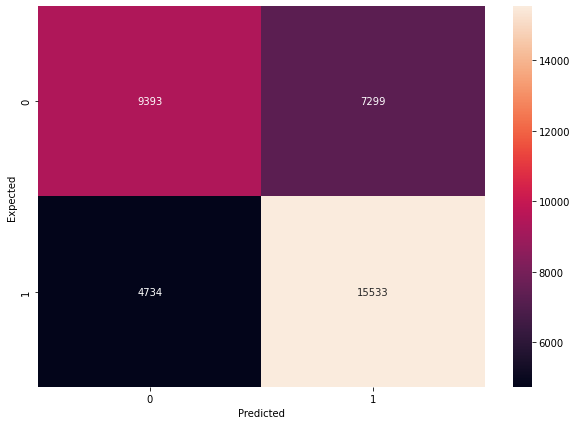

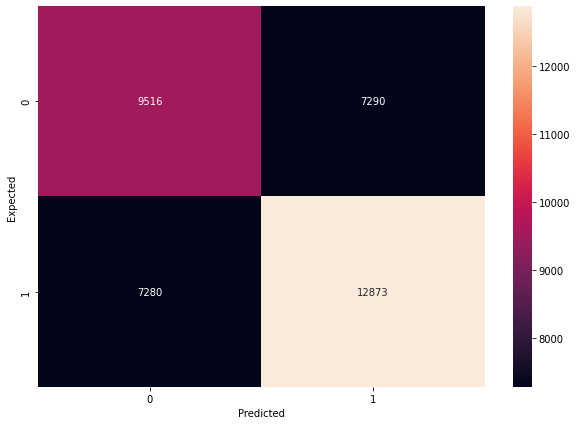

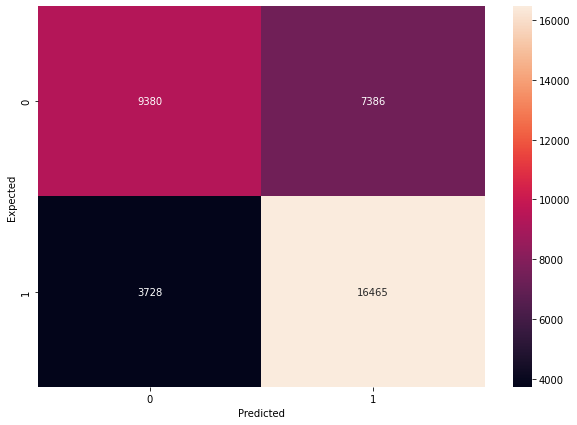

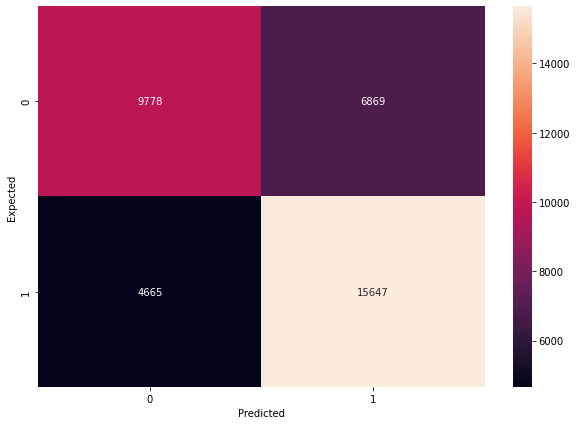

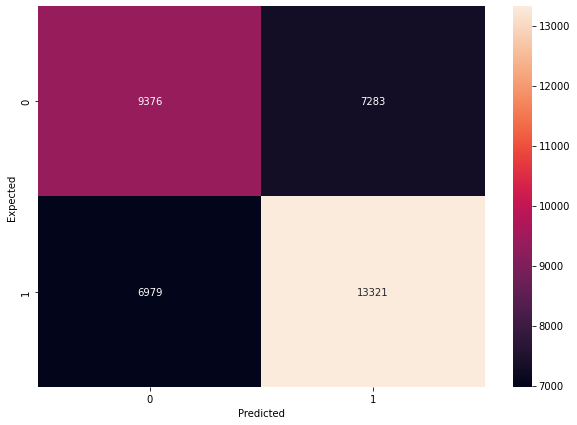

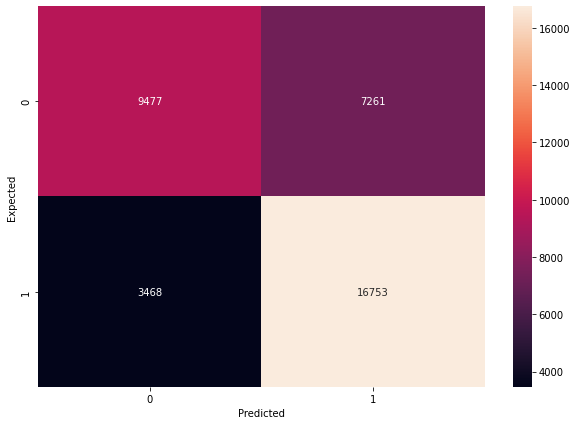

In [ ]:
test_different_vectors_and_classifiers(['UK', 'US'])

## Multiclass
RandomForestClassifier
LogisticRegression
KNeighborsClassifier
LinearSVC
SVC


**************************
Vector Space: word2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.4357209618489251
LogisticRegression(max_iter=30000)
Accuracy: 0.4049905117965276
KNeighborsClassifier()
Accuracy: 0.40660492253660746
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.4025547341886878

**************************
Vector Space: word2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.43893562183136486
LogisticRegression(max_iter=30000)
Accuracy: 0.4011810689098479
KNeighborsClassifier()
Accuracy: 0.4010394539326479
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.40297957912028776

**************************
Vector Space: doc2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.3910414365423287
LogisticRegression(max_iter=30000)
Accuracy: 0.4055286487098876
KNeighborsClassifier()
Accuracy: 0.337454329169853
LinearSVC()
Accuracy: 0.4026680261704478

**************************
Vector Space: doc2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.3825586994080494
LogisticRegression(max_iter=30000)
Accuracy: 0.4012093919052879
KNeighborsClassifier()
Accuracy: 0.3287591695697737
LinearSVC()
Accuracy: 0.39907100574956805


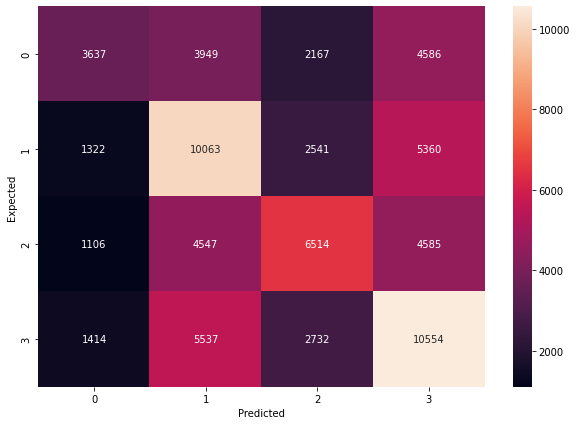

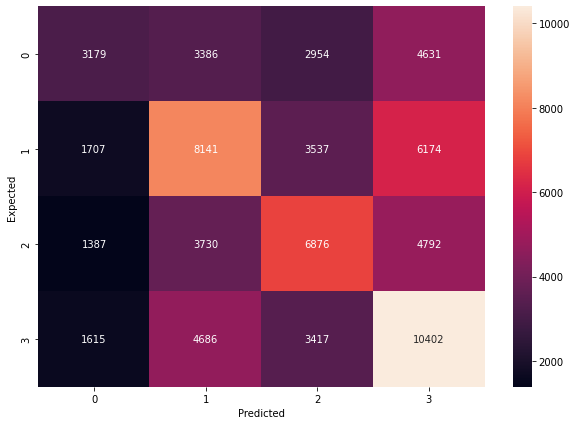

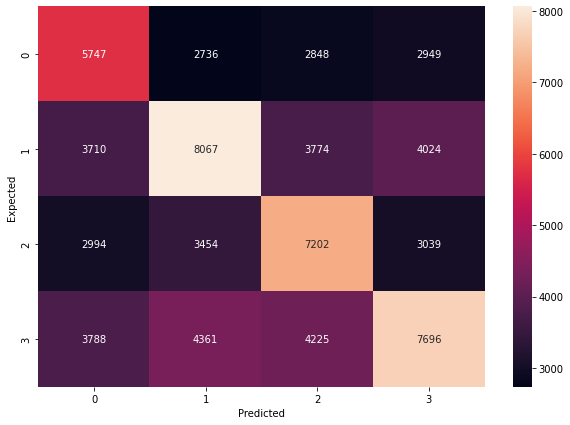

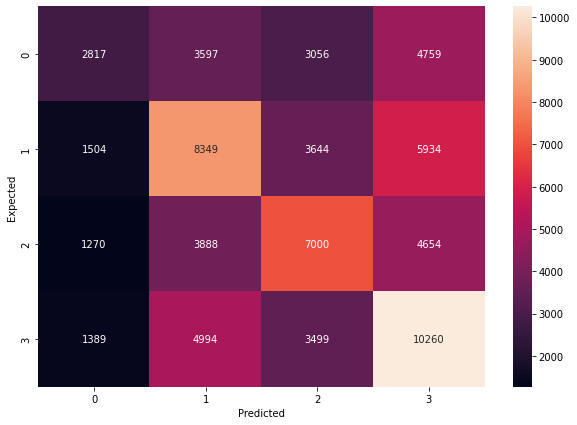

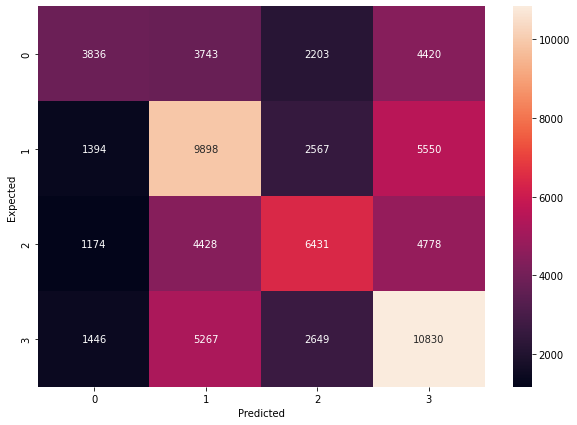

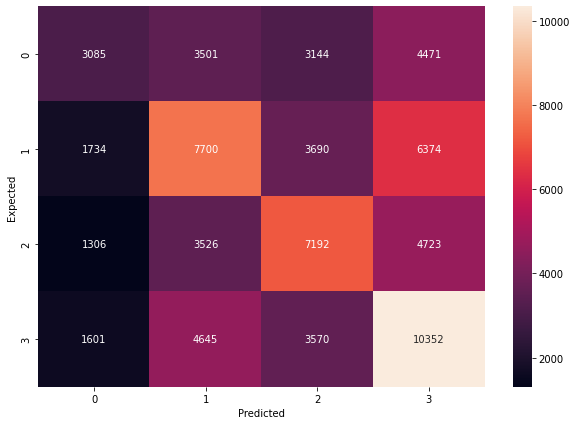

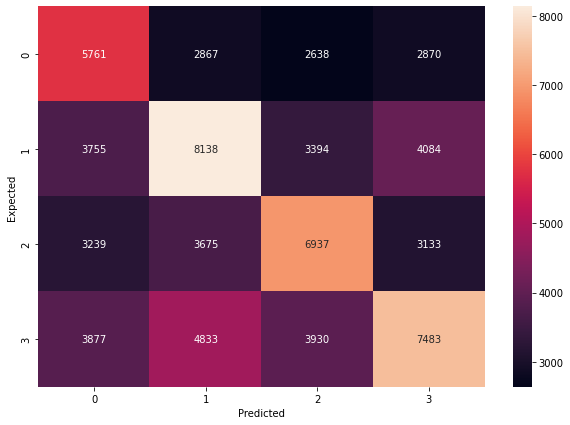

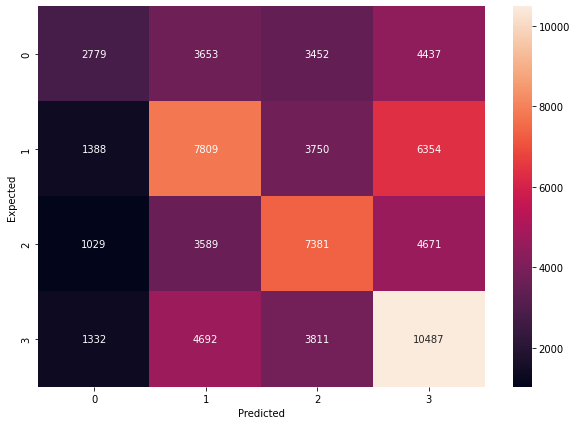

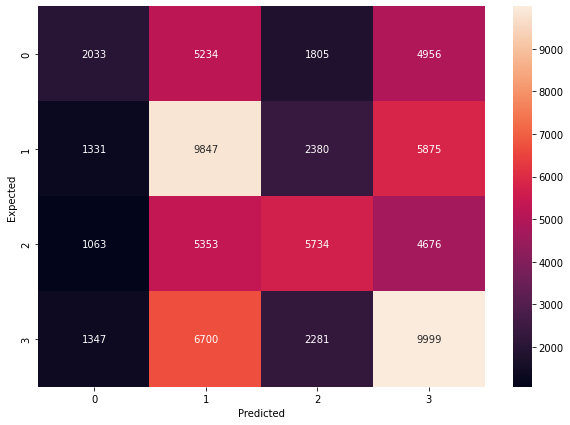

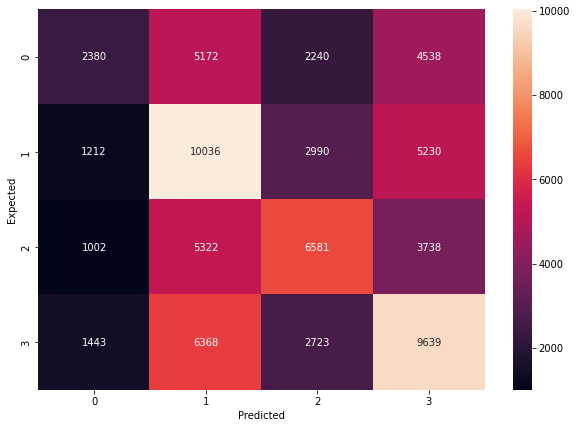

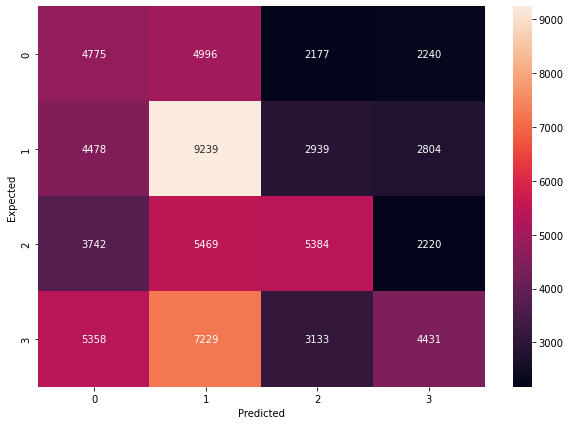

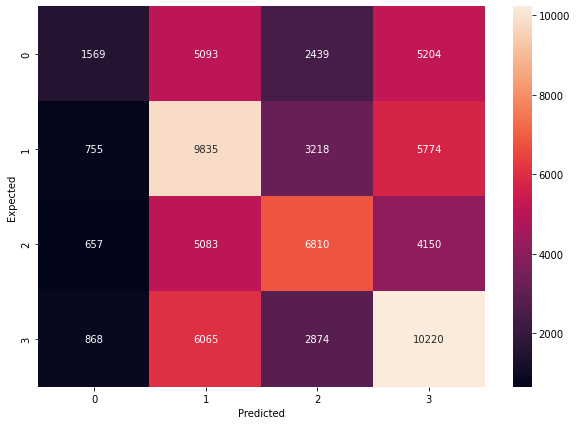

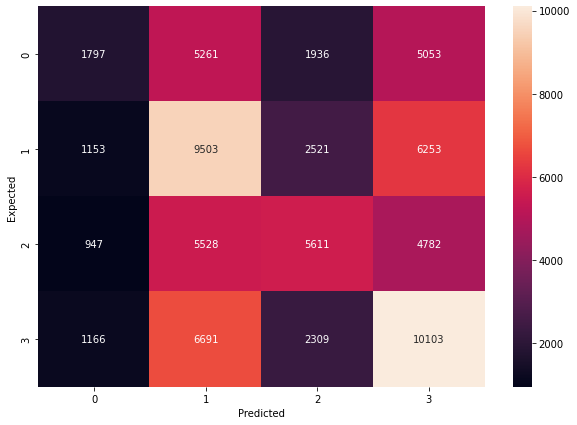

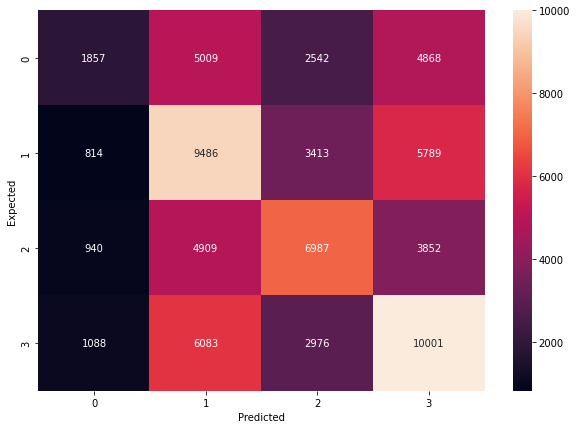

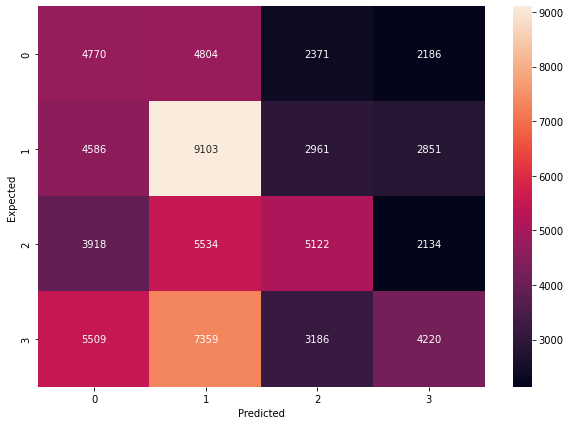

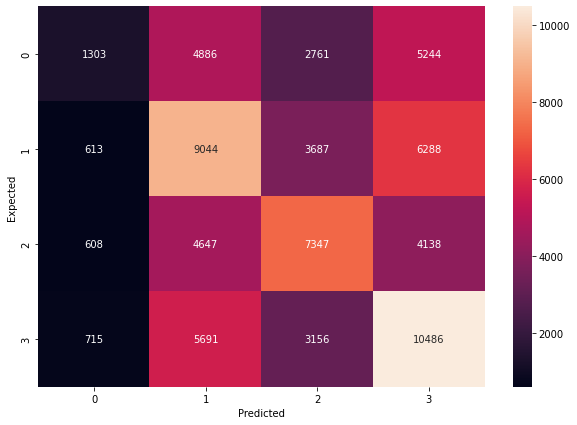

In [ ]:
test_different_vectors_and_classifiers(['UK', 'US', 'Canada', 'Australia']) #last

Accuracy: 0.44188121335712466


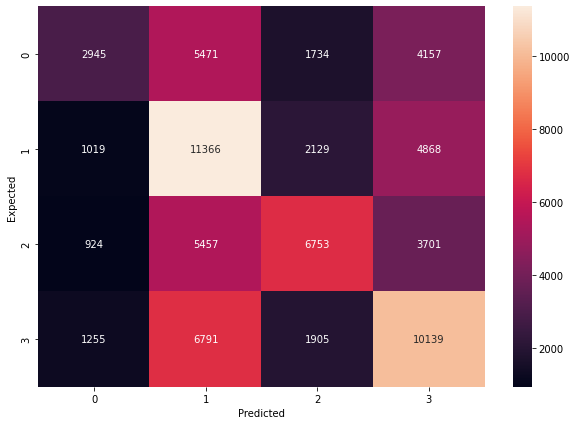

In [ ]:
svc_cl = svm.SVC()
svc_accuracy, svc_res, svc_cm = classify(['US', 'UK', 'Canada', 'Australia'], svc_cl, 'doc2vec_vector') 

Accuracy: 0.44942929164188405


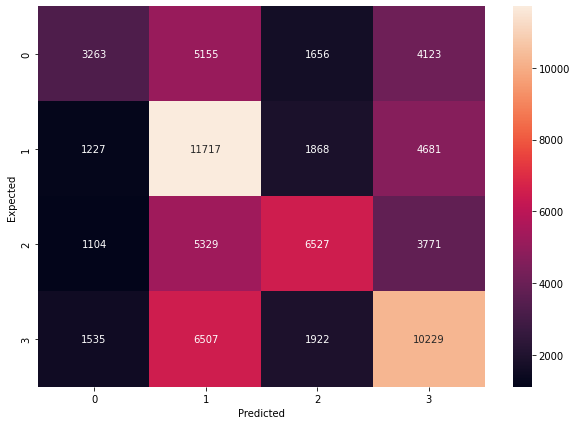

In [ ]:
svc_cl1 = svm.SVC()
svc_accuracy1, svc_res1, svc_cm1 = classify(['US', 'UK', 'Canada', 'Australia'], svc_cl1, 'doc2vec_vector_lem') #last cell run in this version

# Everything below needs to be rerun with this new preprocessing

Accuracy: 0.45090208740476395


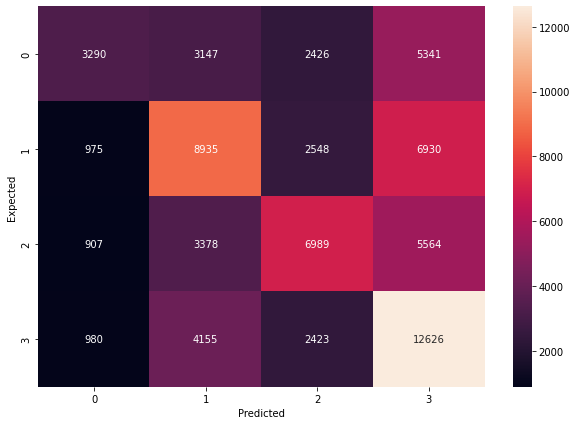

In [ ]:
svc_cl2 = svm.SVC()
svc_accuracy2, svc_res2, svc_cm2 = classify(['US', 'UK', 'Canada', 'Australia'], svc_cl2, 'word2vec_vector') #last cell run in this version

Accuracy: 0.4536777409578837


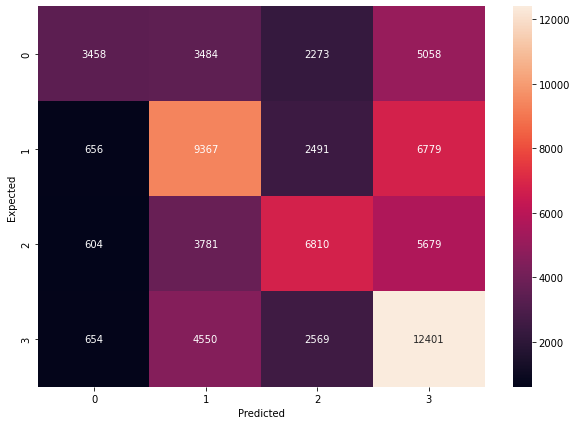

In [ ]:
svc_cl3 = svm.SVC()
svc_accuracy3, svc_res3, svc_cm3 = classify(['US', 'UK', 'Canada', 'Australia'], svc_cl3, 'word2vec_vector_lem')

## UK - Canada
RandomForestClassifier
LogisticRegression
KNeighborsClassifier
LinearSVC


**************************
Vector Space: word2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.669665029523757
LogisticRegression(max_iter=30000)
Accuracy: 0.6415484796644777
KNeighborsClassifier()
Accuracy: 0.6343192980519838
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.6432867943270238

**************************
Vector Space: word2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.6638706473152696
LogisticRegression(max_iter=30000)
Accuracy: 0.6383753655979251
KNeighborsClassifier()
Accuracy: 0.6334915291650571
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.6379338888582308

**************************
Vector Space: doc2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.6491915457204348
LogisticRegression(max_iter=30000)
Accuracy: 0.6487776612769715
KNeighborsClassifier()
Accuracy: 0.6055405330831631
LinearSVC()
Accuracy: 0.6504883836432868

**************************
Vector Space: doc2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.6538546437834557
LogisticRegression(max_iter=30000)
Accuracy: 0.6551514817063075
KNeighborsClassifier()
Accuracy: 0.6136250758788147
LinearSVC()
Accuracy: 0.6547651895590751


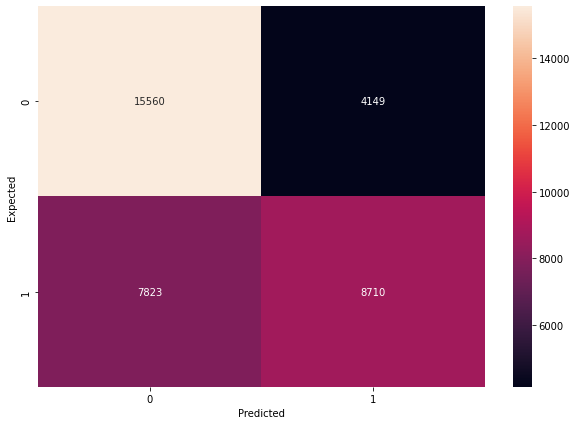

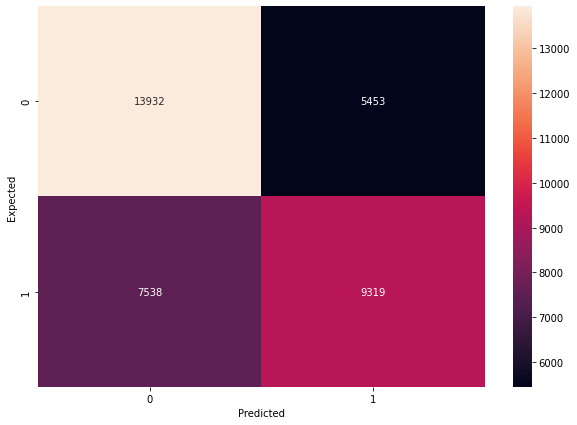

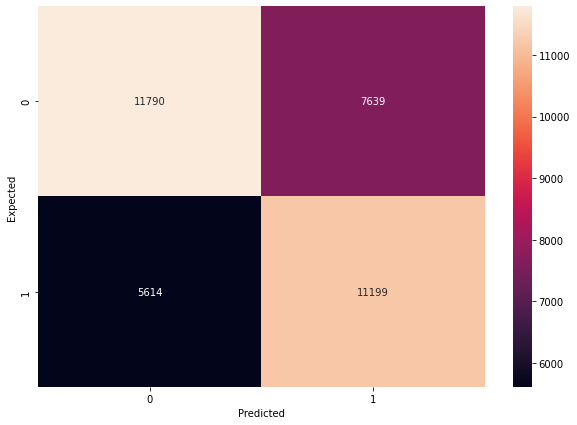

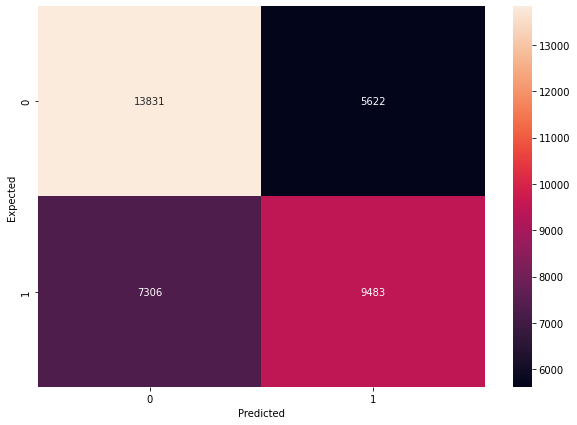

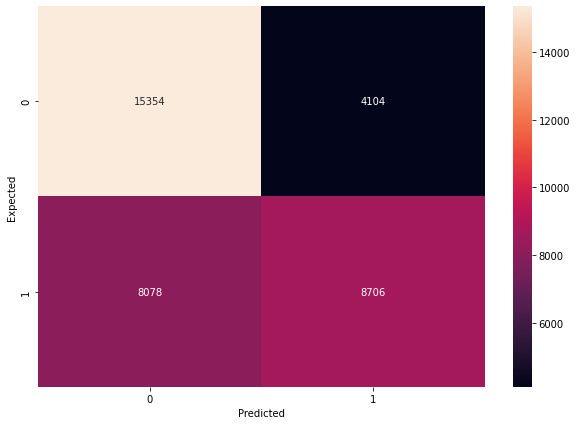

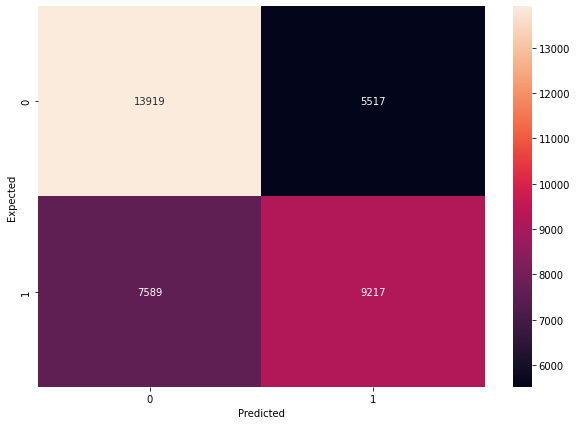

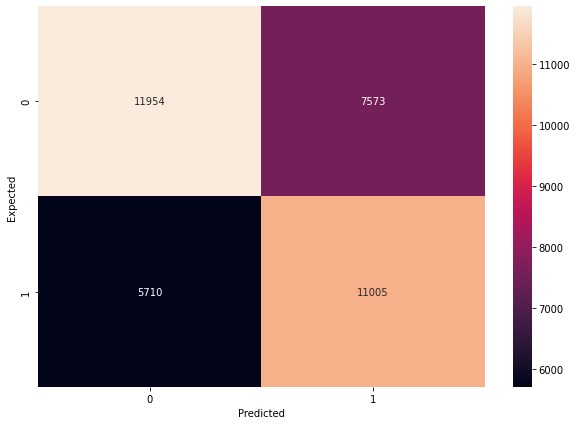

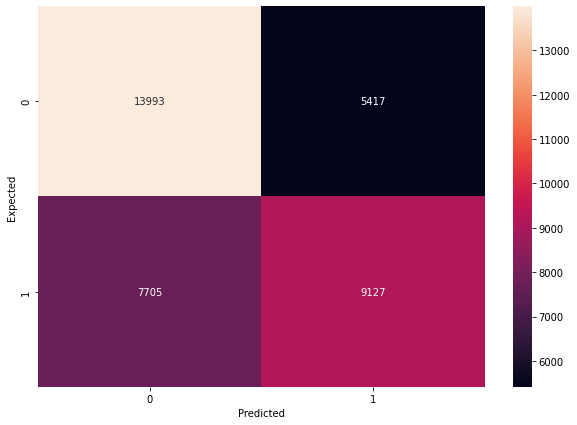

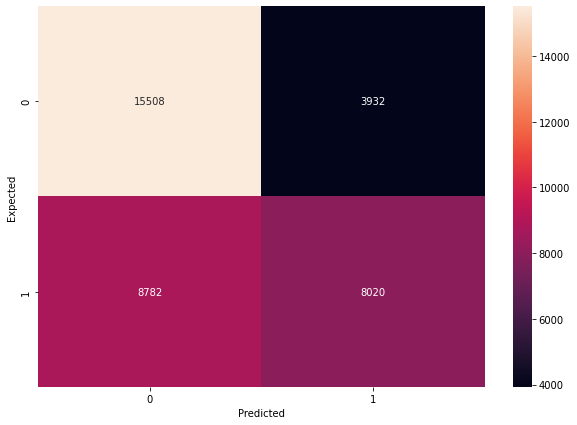

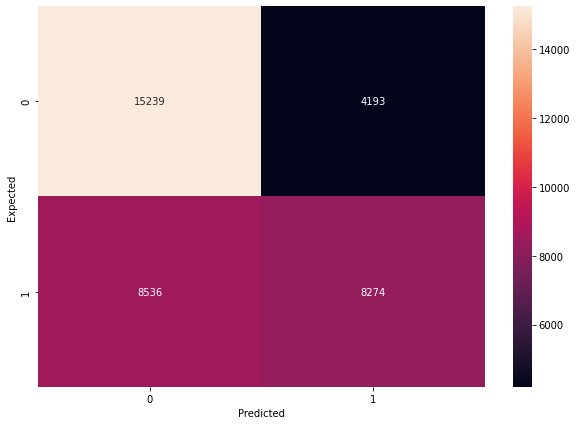

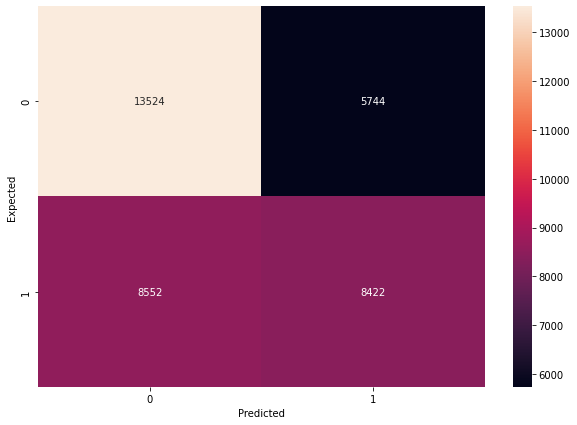

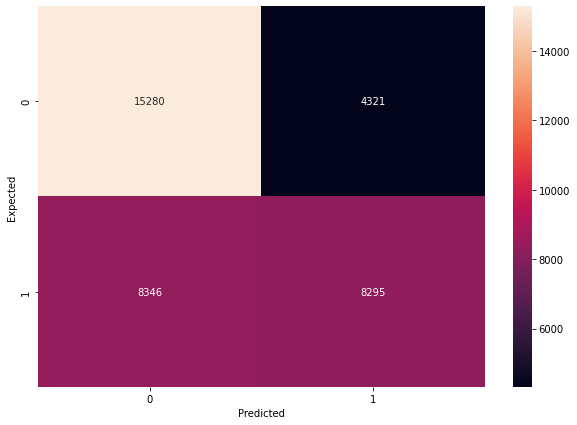

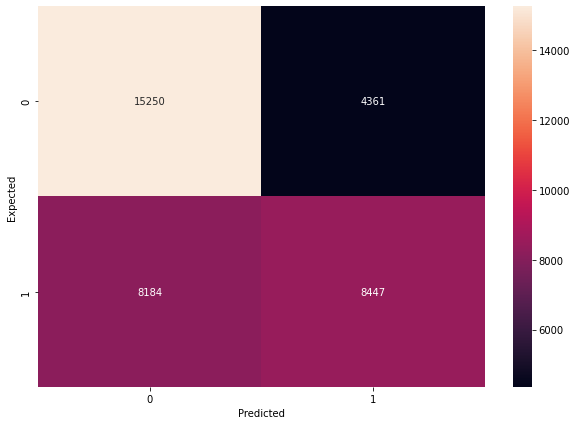

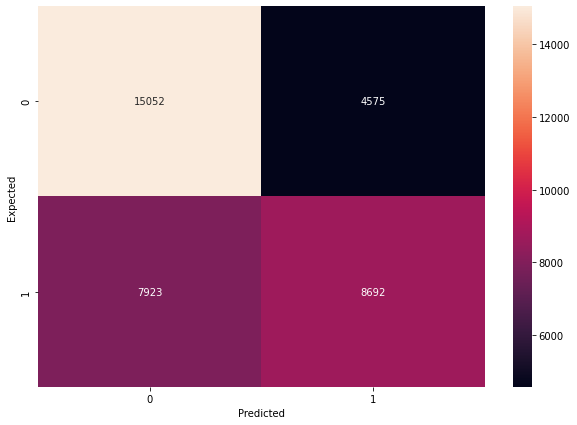

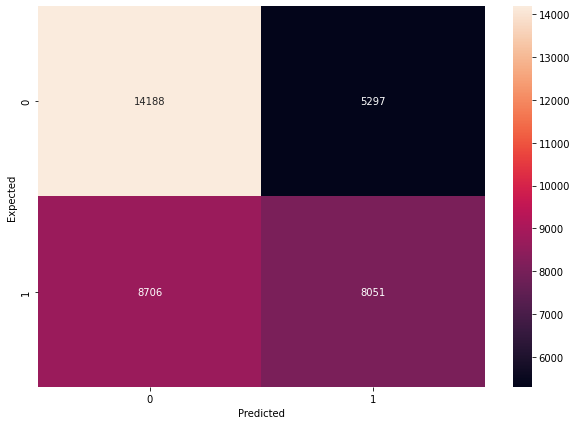

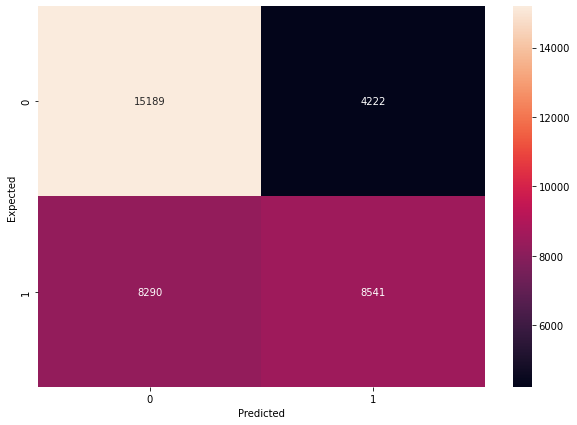

In [ ]:
test_different_vectors_and_classifiers(['UK', 'Canada'])

Accuracy: 0.6815021246068098


(0.6815021246068098,
       predicted_region  ...                                               text
 0                   UK  ...  [0.2952365415170789, 0.4353377167135477, 0.359...
 1                   UK  ...  [0.08416450334091981, 0.19525894584755102, 0.5...
 2               Canada  ...  [-0.7036314229754841, -0.10835984847782289, 0....
 3               Canada  ...  [-0.12369808480919649, -0.20069048056029715, 0...
 4               Canada  ...  [-0.27997069087411675, -0.20414301114422934, 0...
 ...                ...  ...                                                ...
 36237               UK  ...  [0.18064124137163162, 0.0019253618357812658, 0...
 36238           Canada  ...  [0.21988850193156395, 0.015011955285444856, 0....
 36239           Canada  ...  [-0.022786630026530474, -0.15205162569570044, ...
 36240           Canada  ...  [0.6494352662173862, 0.4610593044622378, 0.875...
 36241               UK  ...  [0.22686348922169683, 0.5373784833672371, 0.86...
 
 [36242 rows x 3 

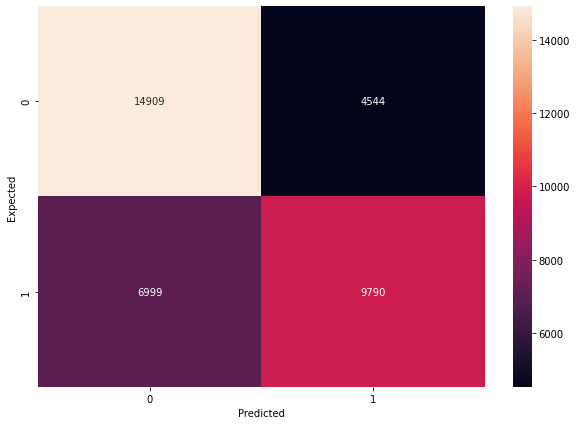

In [ ]:
svc_cl_uk_ca = svm.SVC()
classify(['UK', 'Canada'], svc_cl_uk_ca, 'word2vec_vector_lem')

Accuracy: 0.6790464102422603


(0.6790464102422603,
       predicted_region  ...                                               text
 0                   UK  ...  [-0.2538635386405764, -0.5242807396461029, 0.3...
 1               Canada  ...  [-0.33388379553989433, -1.5144048400956098, 0....
 2                   UK  ...  [0.05110400294264158, -1.302713605420043, 0.56...
 3                   UK  ...  [-0.10043580203571102, -0.5340973185375333, 0....
 4               Canada  ...  [-0.08982003537508157, -1.189917042851448, 0.9...
 ...                ...  ...                                                ...
 36237           Canada  ...  [0.24944618344306946, -0.502493143081665, 0.32...
 36238               UK  ...  [0.01955777406692505, -0.6611369252204895, 0.2...
 36239               UK  ...  [0.018837290943007578, -0.684711703104602, -0....
 36240           Canada  ...  [-0.385419678281654, -0.9664816070686687, 0.40...
 36241           Canada  ...  [0.27238109707832336, -0.7726410031318665, 0.3...
 
 [36242 rows x 3 

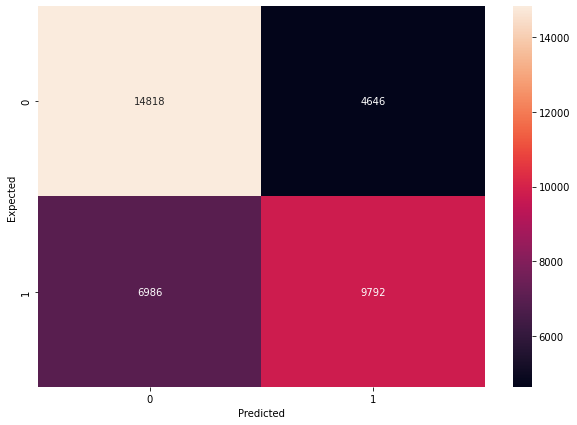

In [ ]:
classify(['UK', 'Canada'], svc_cl_uk_ca, 'word2vec_vector')

Accuracy: 0.6901936979195409


(0.6901936979195409,
       predicted_region  ...                                               text
 0                   UK  ...  [0.0442550927400589, -0.11816828697919846, -0....
 1               Canada  ...  [0.014880393631756306, -0.00713540380820632, -...
 2               Canada  ...  [-0.12036009132862091, -0.05236583948135376, 0...
 3                   UK  ...  [0.009318514727056026, 0.008995807729661465, -...
 4                   UK  ...  [-0.034431908279657364, -0.12167897820472717, ...
 ...                ...  ...                                                ...
 36237           Canada  ...  [0.010835811495780945, 0.012739117257297039, 0...
 36238           Canada  ...  [-0.017702359706163406, -0.06416216492652893, ...
 36239               UK  ...  [0.029522867873311043, -0.02990795113146305, 0...
 36240           Canada  ...  [0.0170331709086895, -0.04845964536070824, -0....
 36241           Canada  ...  [0.0022912640124559402, -0.06387799978256226, ...
 
 [36242 rows x 3 

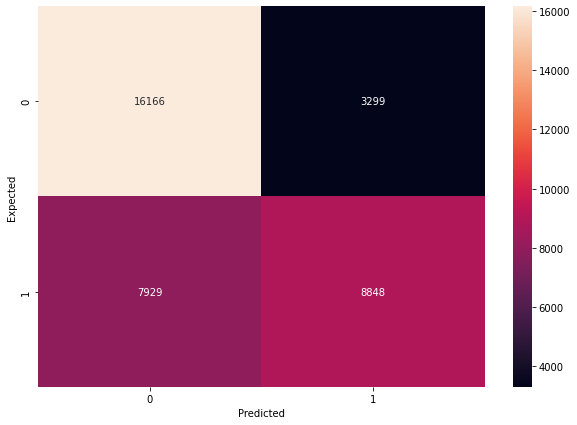

In [ ]:
classify(['UK', 'Canada'], svc_cl_uk_ca, 'doc2vec_vector_lem')

Accuracy: 0.6887037139230727


(0.6887037139230727,
       predicted_region  ...                                               text
 0               Canada  ...  [0.011734351515769958, -0.051953498274087906, ...
 1               Canada  ...  [0.05613230913877487, -0.008997635915875435, -...
 2               Canada  ...  [-0.010144044645130634, 0.07466024905443192, 0...
 3               Canada  ...  [0.023191602900624275, -0.09413822740316391, 0...
 4               Canada  ...  [-0.02269999124109745, -0.09022589772939682, -...
 ...                ...  ...                                                ...
 36237           Canada  ...  [0.004378381185233593, 0.048293452709913254, 0...
 36238               UK  ...  [-0.040241535753011703, 0.03164016082882881, 0...
 36239           Canada  ...  [0.010293891653418541, -0.02299514040350914, -...
 36240           Canada  ...  [0.04328638315200806, -0.02859271503984928, 0....
 36241               UK  ...  [0.06641057878732681, -0.01396289374679327, -0...
 
 [36242 rows x 3 

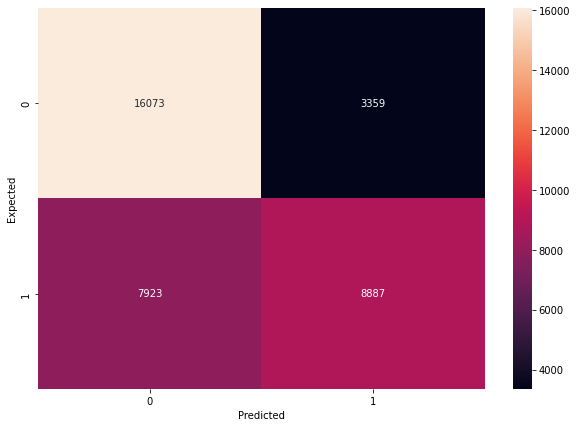

In [ ]:
classify(['UK', 'Canada'], svc_cl_uk_ca, 'doc2vec_vector')

## UK - Australia
RandomForestClassifier
LogisticRegression
KNeighborsClassifier
LinearSVC


**************************
Vector Space: word2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.6721931355439209
LogisticRegression(max_iter=30000)
Accuracy: 0.6476310516450132
KNeighborsClassifier()
Accuracy: 0.6503781268179174
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.6503458082864715

**************************
Vector Space: word2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.6602029603774805
LogisticRegression(max_iter=30000)
Accuracy: 0.6502811712235796
KNeighborsClassifier()
Accuracy: 0.6471785922047703
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.6502165341606877

**************************
Vector Space: doc2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.6418783530476375
LogisticRegression(max_iter=30000)
Accuracy: 0.6498287117833366
KNeighborsClassifier()
Accuracy: 0.595242712171159
LinearSVC()
Accuracy: 0.6509921789153901

**************************
Vector Space: doc2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.6473078663305539
LogisticRegression(max_iter=30000)
Accuracy: 0.6457242582897034
KNeighborsClassifier()
Accuracy: 0.6010923663628724
LinearSVC()
Accuracy: 0.6502811712235796


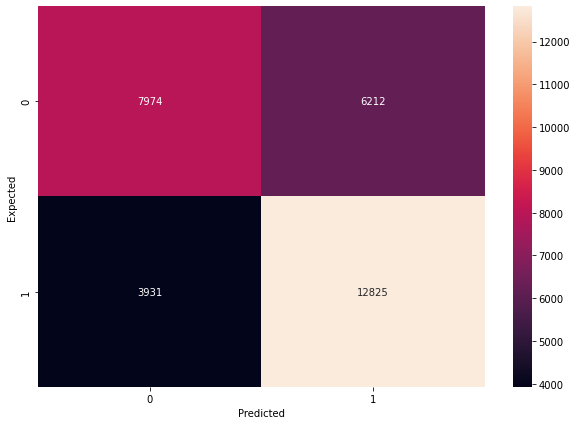

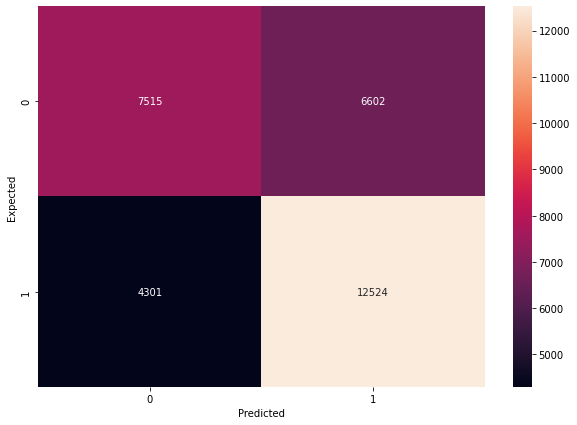

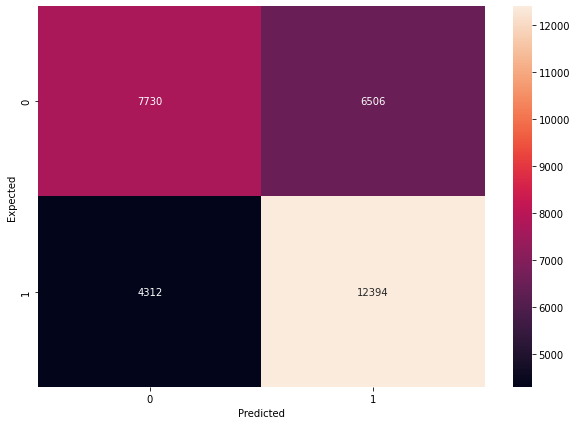

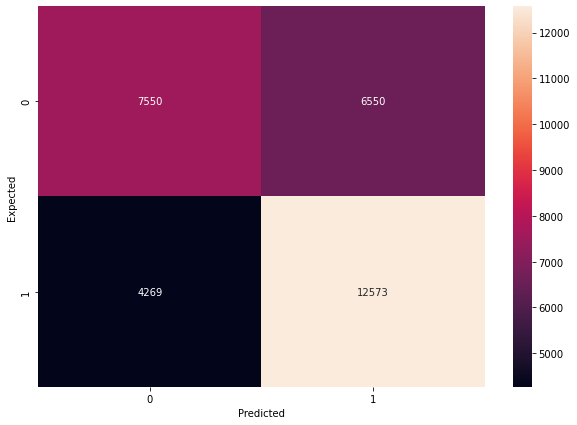

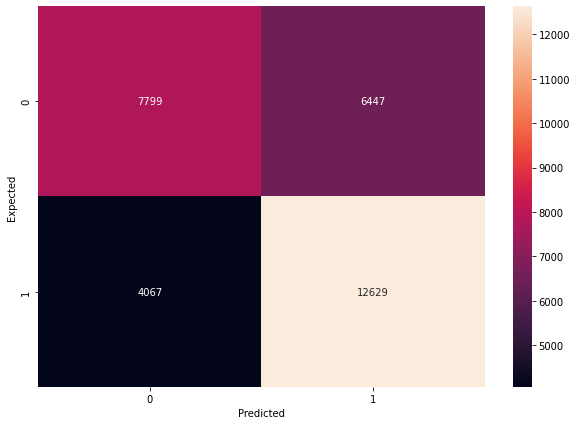

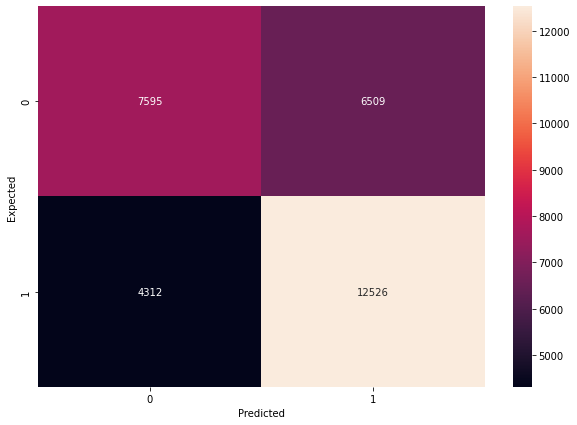

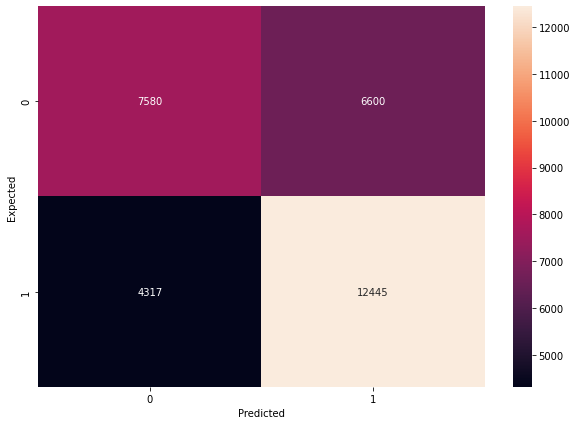

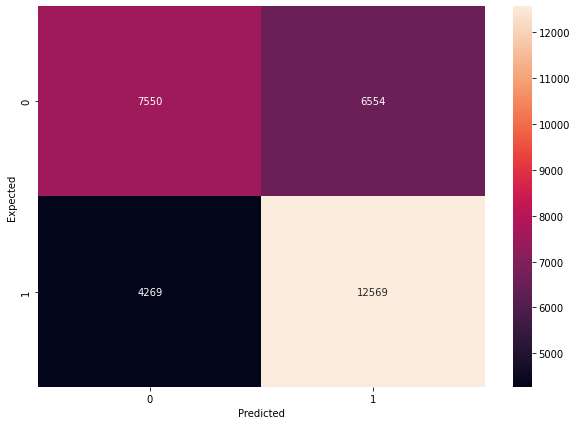

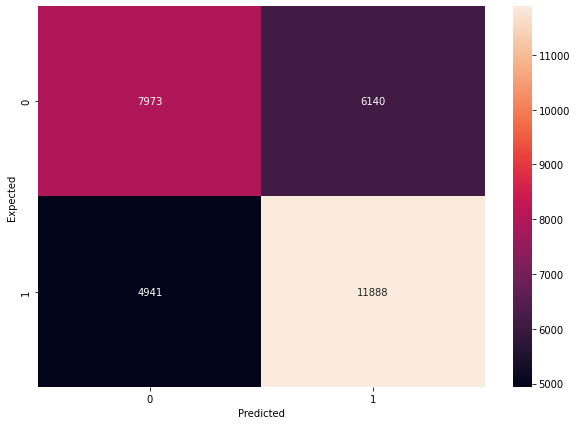

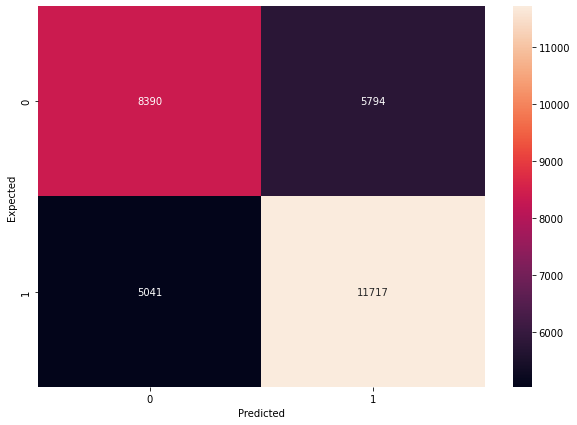

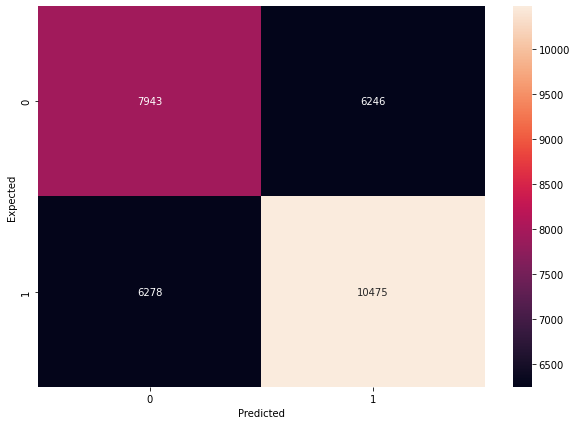

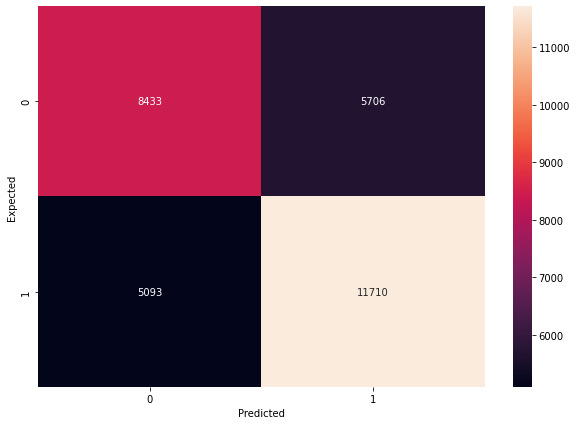

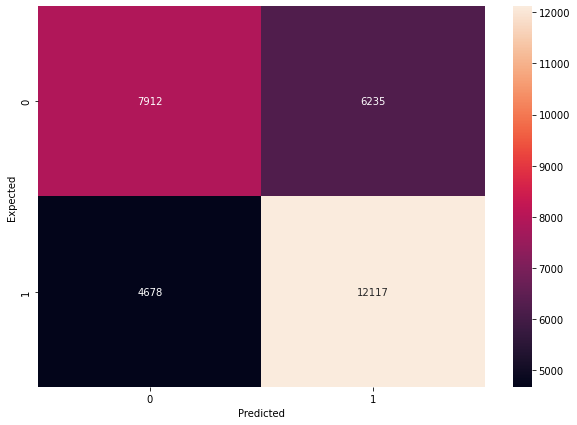

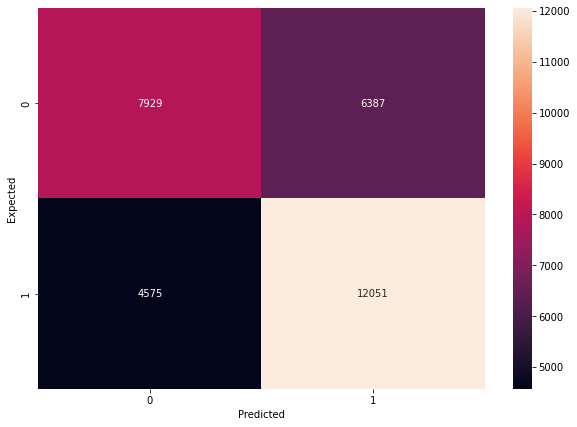

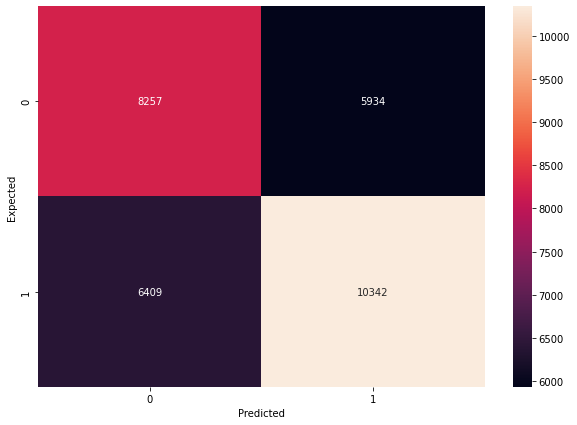

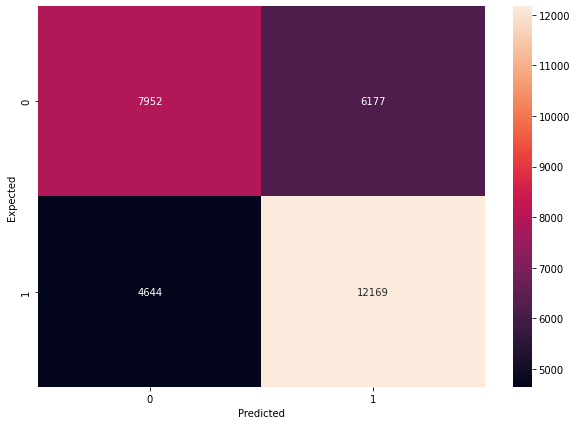

In [ ]:
test_different_vectors_and_classifiers(['UK', 'Australia'])

Accuracy: 0.6784629306444315


(0.6784629306444315,
       predicted_region  ...                                               text
 0            Australia  ...  [0.6542641975296041, -0.19557159952819347, 0.8...
 1            Australia  ...  [-0.03014993891119957, -0.36231557056307795, 0...
 2                   UK  ...  [-0.5713088611761729, -0.23243267905144466, 0....
 3            Australia  ...  [0.05193761410191655, -0.07825137954205275, 0....
 4                   UK  ...  [0.1635966981546237, -0.0757244871212886, 0.17...
 ...                ...  ...                                                ...
 30937               UK  ...  [0.14535835655849605, 0.4257651301366942, 0.95...
 30938               UK  ...  [0.161037572623732, 0.2498336240935784, 0.3817...
 30939               UK  ...  [0.6181818663349582, -0.5158304170601897, 0.13...
 30940        Australia  ...  [0.5823068127036095, 0.5822651624679566, 0.095...
 30941               UK  ...  [-0.10962703845774134, -0.33898225526014963, 0...
 
 [30942 rows x 3 

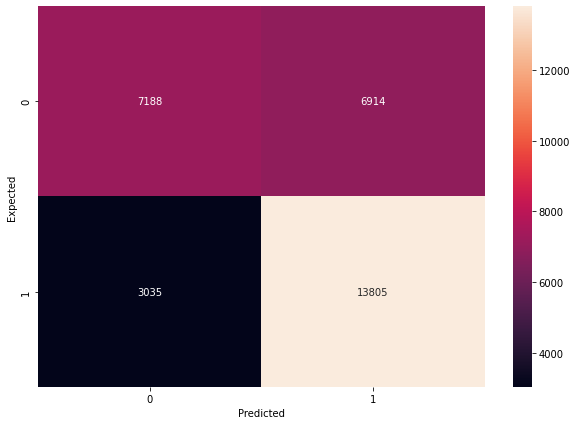

In [ ]:
svc_cl_uk_au = svm.SVC()
classify(['UK', 'Australia'], svc_cl_uk_au, 'word2vec_vector_lem')

Accuracy: 0.6801758128110659


(0.6801758128110659,
       predicted_region  ...                                               text
 0            Australia  ...  [0.3031863272190094, -0.10621414333581924, 0.4...
 1                   UK  ...  [0.5732591822743416, -0.6413074823406836, 0.02...
 2                   UK  ...  [-0.3615792196088781, -0.8549797215498984, 0.5...
 3            Australia  ...  [-0.570354792044351, -0.9333938874892498, 0.69...
 4                   UK  ...  [-0.5621640402047584, -0.9061677726408974, 0.4...
 ...                ...  ...                                                ...
 30937               UK  ...  [0.3598249554634094, -2.370523452758789, 1.746...
 30938               UK  ...  [-0.46150570352898634, -0.752433719559315, 0.4...
 30939        Australia  ...  [0.7581054931506515, -0.29804525524377823, 0.1...
 30940               UK  ...  [-0.5143354224803095, -0.5032779772115067, 0.3...
 30941               UK  ...  [-0.0938859021823321, -0.6331110123677978, 0.3...
 
 [30942 rows x 3 

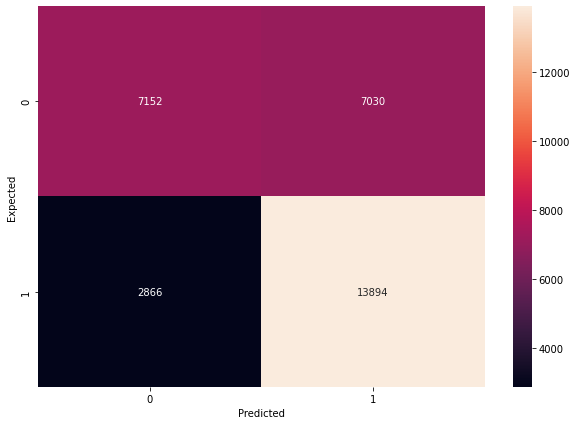

In [ ]:
classify(['UK', 'Australia'], svc_cl_uk_au, 'word2vec_vector')

Accuracy: 0.6800465386852821


(0.6800465386852821,
       predicted_region  ...                                               text
 0                   UK  ...  [-0.01439585816115141, -0.025426849722862244, ...
 1            Australia  ...  [-0.025645006448030472, -0.15785503387451172, ...
 2            Australia  ...  [-0.008537327870726585, 0.0007268911576829851,...
 3            Australia  ...  [0.0019516973989084363, 0.026580356061458588, ...
 4            Australia  ...  [0.005701161455363035, -0.1070394292473793, -0...
 ...                ...  ...                                                ...
 30937        Australia  ...  [0.014867935329675674, -0.010456094518303871, ...
 30938               UK  ...  [-0.01058577187359333, -0.09257439523935318, -...
 30939               UK  ...  [0.0688922181725502, -0.10765454918146133, -0....
 30940        Australia  ...  [-0.016578786075115204, -0.0755053386092186, -...
 30941        Australia  ...  [0.015465406700968742, -0.051377374678850174, ...
 
 [30942 rows x 3 

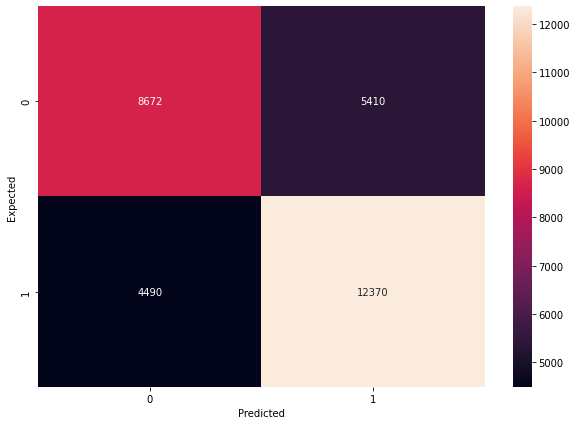

In [ ]:
classify(['UK', 'Australia'], svc_cl_uk_au, 'doc2vec_vector_lem')

Accuracy: 0.68760907504363


(0.68760907504363,
       predicted_region  ...                                               text
 0                   UK  ...  [0.04234642535448074, -0.04913513734936714, -0...
 1            Australia  ...  [0.021957973018288612, 0.03255951777100563, 0....
 2            Australia  ...  [-0.00952971912920475, -0.019287176430225372, ...
 3                   UK  ...  [0.004187168553471565, -0.019188791513442993, ...
 4                   UK  ...  [0.05688484013080597, -0.033212557435035706, -...
 ...                ...  ...                                                ...
 30937               UK  ...  [0.06741435825824738, 0.01119015272706747, -0....
 30938        Australia  ...  [0.011855002492666245, -0.013112055137753487, ...
 30939        Australia  ...  [0.012809745967388153, 0.06016860157251358, 0....
 30940               UK  ...  [0.025066453963518143, -0.015247040428221226, ...
 30941               UK  ...  [0.039691559970378876, 0.008070035837590694, 0...
 
 [30942 rows x 3 co

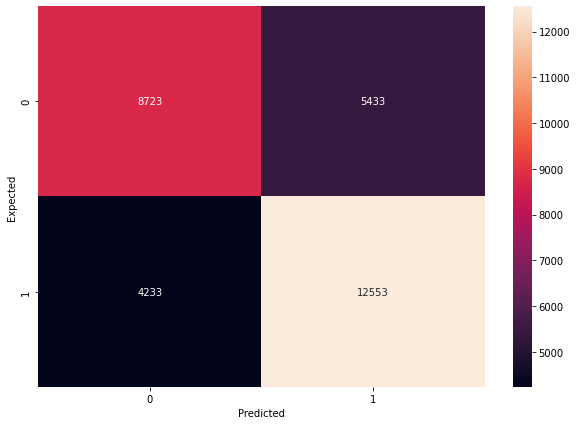

In [ ]:
classify(['UK', 'Australia'], svc_cl_uk_au, 'doc2vec_vector')

## UK - US
RandomForestClassifier
LogisticRegression
KNeighborsClassifier
LinearSVC



**************************
Vector Space: word2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.6618685570497037
LogisticRegression(max_iter=30000)
Accuracy: 0.6462296057793772
KNeighborsClassifier()
Accuracy: 0.637544305852431
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.6494223328553261

**************************
Vector Space: word2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.658324088855218
LogisticRegression(max_iter=30000)
Accuracy: 0.6505857842474093
KNeighborsClassifier()
Accuracy: 0.6273167564057469
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.6499634730376904

**************************
Vector Space: doc2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.656159528125761
LogisticRegression(max_iter=30000)
Accuracy: 0.6749912064720366
KNeighborsClassifier()
Accuracy: 0.60320896128142
LinearSVC()
Accuracy: 0.6765334559917747

**************************
Vector Space: doc2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.6599745664114289
LogisticRegression(max_iter=30000)
Accuracy: 0.6858681241375578
KNeighborsClassifier()
Accuracy: 0.6122189453177845
LinearSVC()
Accuracy: 0.6881679699126059


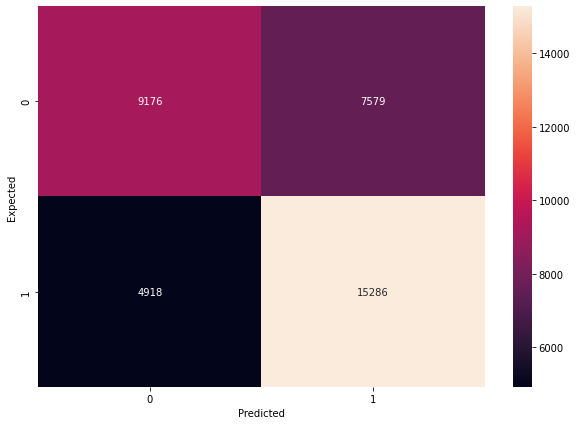

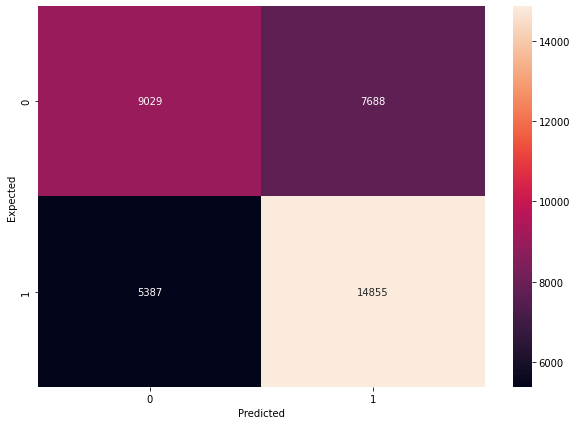

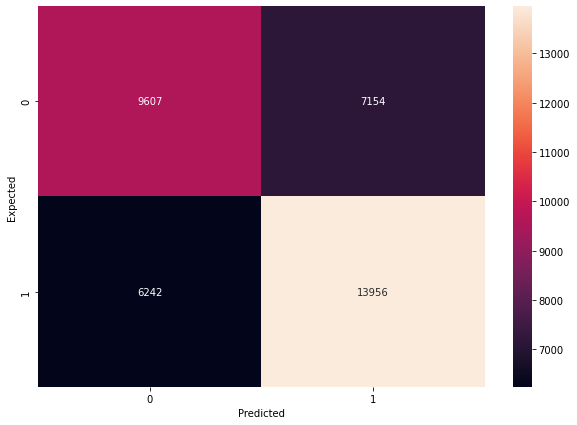

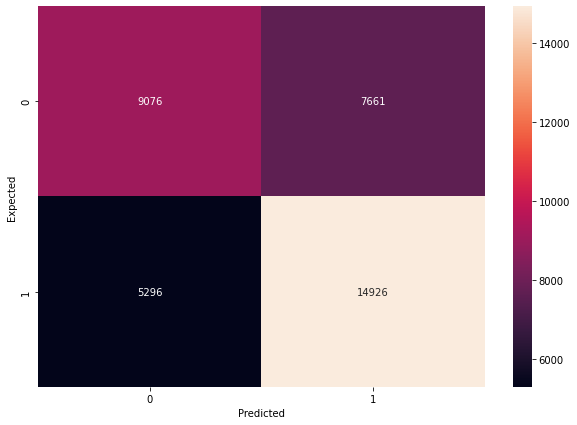

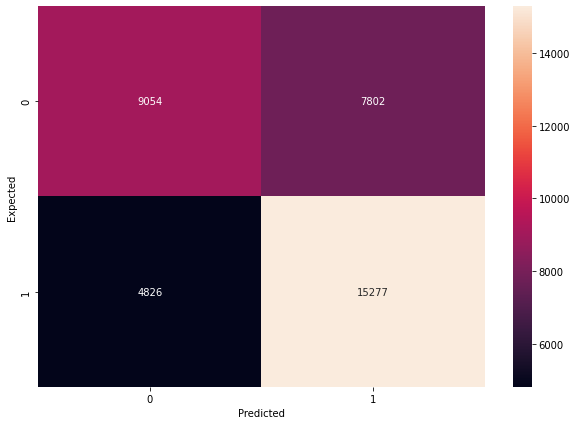

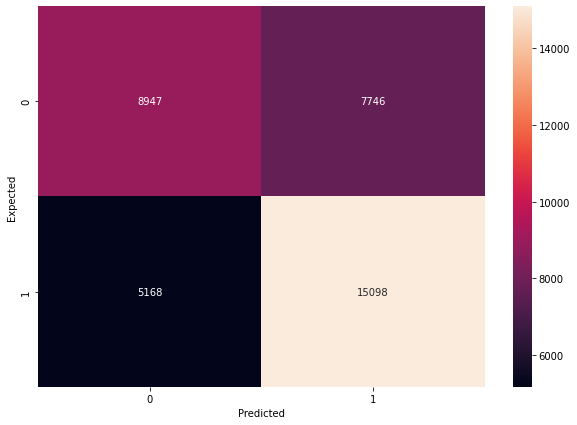

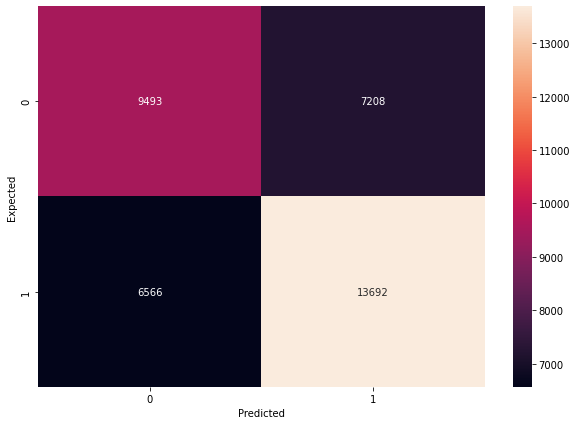

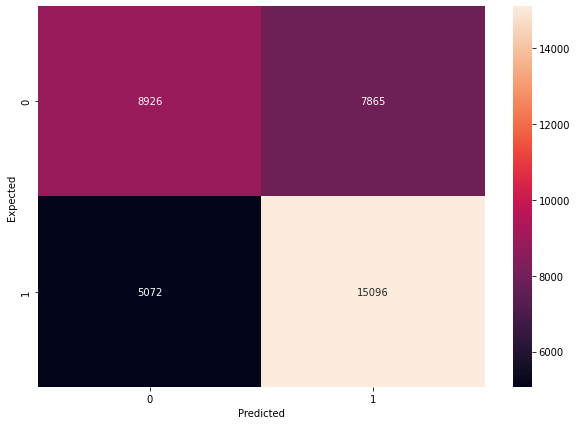

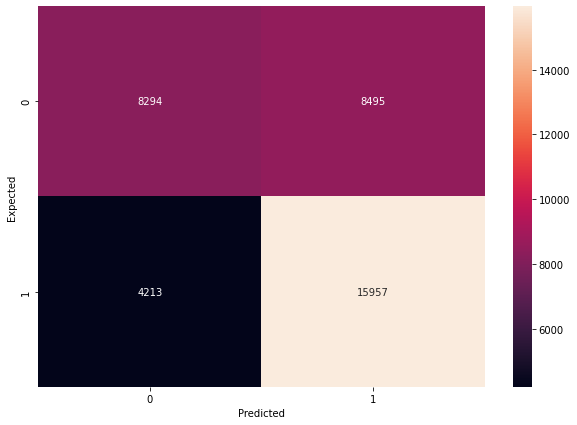

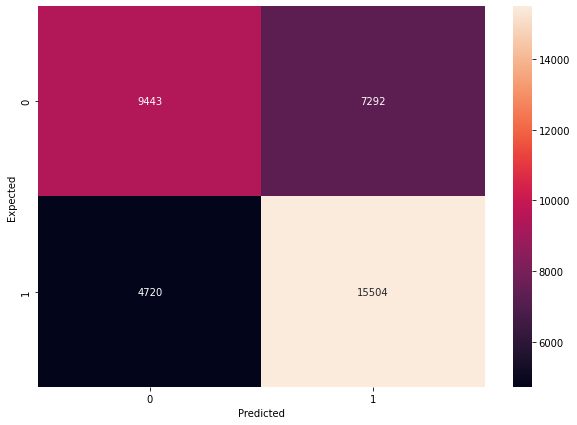

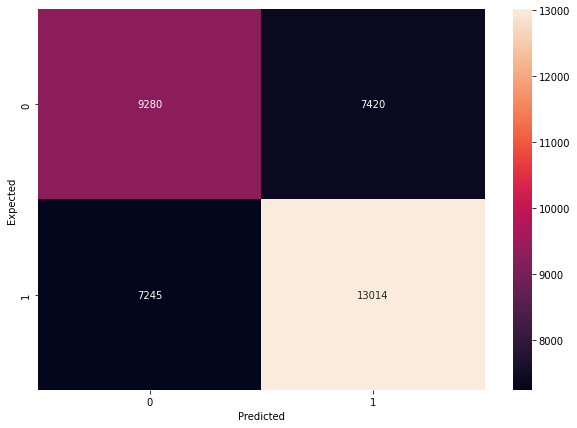

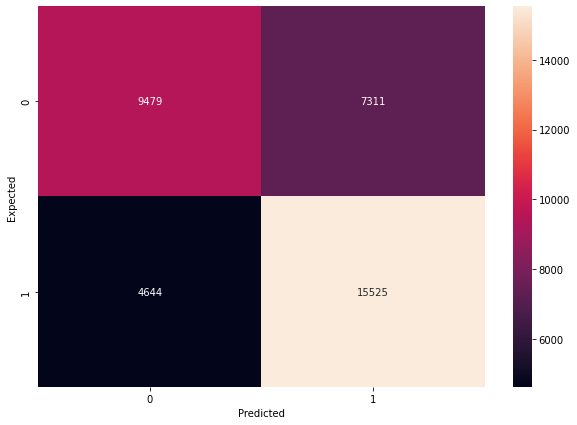

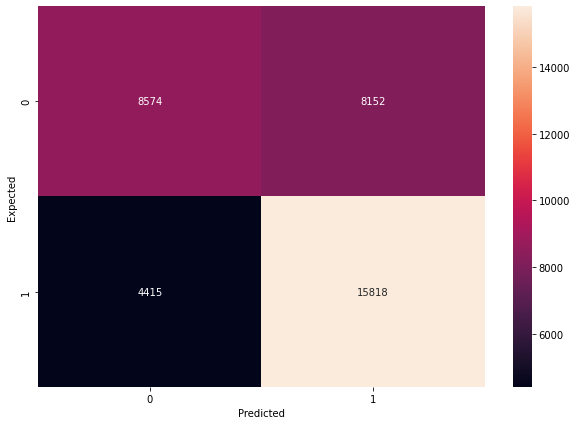

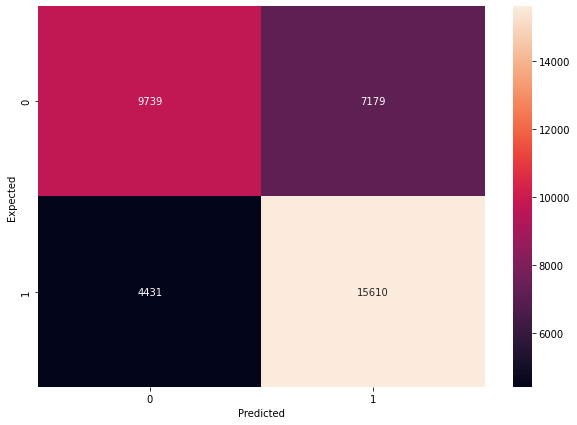

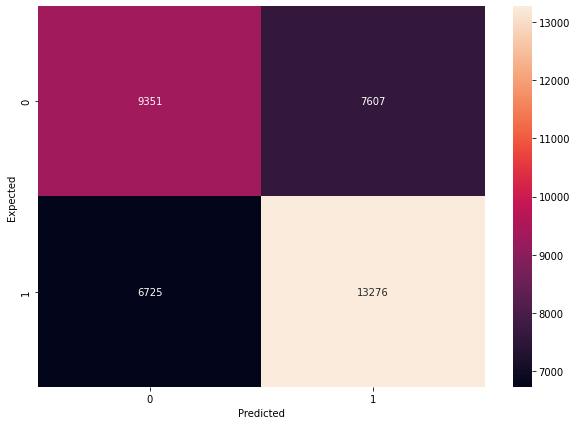

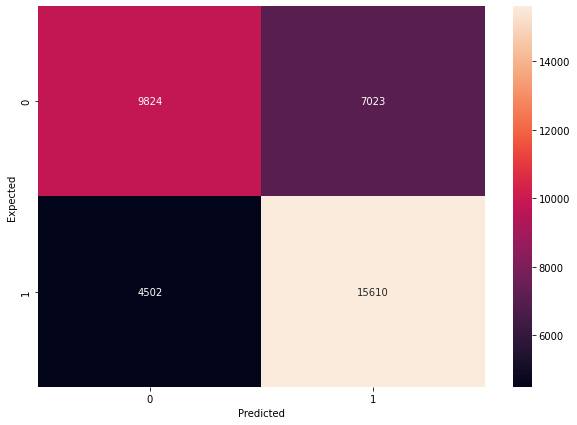

In [ ]:
test_different_vectors_and_classifiers(['UK', 'US'])

Accuracy: 0.6738548120890717


(0.6738548120890717,
       predicted_region  ...                                               text
 0                   UK  ...  [0.07980860187025327, -0.18675371512977612, 0....
 1                   US  ...  [-0.1749531343917955, -0.37193501550196245, 0....
 2                   UK  ...  [-0.5702115003950894, -0.38965281564742327, 0....
 3                   US  ...  [-0.0031322816567909387, 0.061514220045258604,...
 4                   UK  ...  [0.0803419235162437, 0.12416521930380871, 0.95...
 ...                ...  ...                                                ...
 36954               US  ...  [-0.3957020992305703, -0.4836426873046618, 0.1...
 36955               US  ...  [-0.0029819853102358487, 0.5251042600721121, 0...
 36956               US  ...  [-0.33619054932413356, -0.3061211427141513, 0....
 36957               US  ...  [0.38604015180109336, 0.03479308395513466, 0.8...
 36958               US  ...  [0.14957747980952263, -0.3831600248813629, 0.5...
 
 [36959 rows x 3 

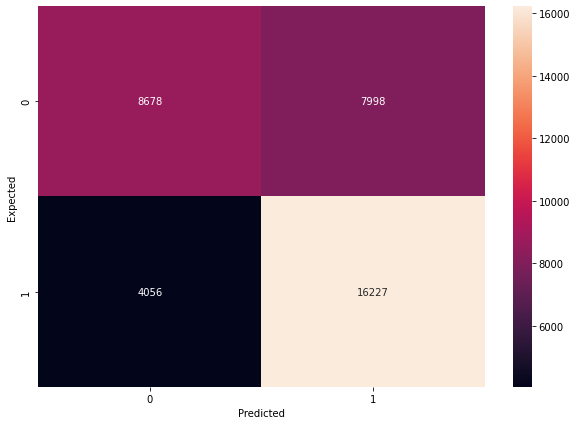

In [ ]:
svc_cl_uk_us = svm.SVC()
classify(['UK', 'US'], svc_cl_uk_us, 'word2vec_vector_lem')

Accuracy: 0.6783733326118131


(0.6783733326118131,
       predicted_region  ...                                               text
 0                   UK  ...  [0.6229106783866882, -1.2877862453460693, 0.93...
 1                   US  ...  [0.04221126437187195, -1.5069135427474976, 0.2...
 2                   US  ...  [-0.05550344229528779, -0.9653045235348767, 0....
 3                   US  ...  [-0.16108356898321824, -0.874627170536448, 0.7...
 4                   UK  ...  [0.24800822163081687, -0.3197248186814882, 0.4...
 ...                ...  ...                                                ...
 36954               US  ...  [-0.029756576884264016, -1.1662290019585806, 0...
 36955               US  ...  [-0.3161120948366701, -0.8107310267946413, 0.6...
 36956               US  ...  [0.25585602049250156, -0.21126328951989612, 0....
 36957               US  ...  [-0.6650730676356365, -1.4080338778566908, -0....
 36958               UK  ...  [0.6041943430900574, -0.4646233320236206, 0.42...
 
 [36959 rows x 3 

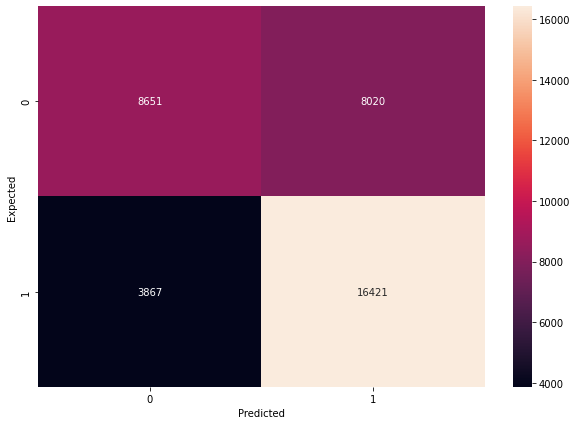

In [ ]:
classify(['UK', 'US'], svc_cl_uk_us, 'word2vec_vector')

Accuracy: 0.7021564436267215


(0.7021564436267215,
       predicted_region  ...                                               text
 0                   UK  ...  [-0.010981407947838306, -0.052248578518629074,...
 1                   US  ...  [0.028053829446434975, -0.00384873547591269, -...
 2                   US  ...  [0.0033681599888950586, 0.007860656827688217, ...
 3                   US  ...  [0.011414598673582077, 0.008270159363746643, -...
 4                   UK  ...  [-0.015869690105319023, -0.054133340716362, -0...
 ...                ...  ...                                                ...
 36954               US  ...  [0.0026054212357848883, -0.03163754567503929, ...
 36955               US  ...  [0.0035669070202857256, -0.07481333613395691, ...
 36956               US  ...  [0.0058834971860051155, -0.03749000281095505, ...
 36957               US  ...  [-0.04719506949186325, 0.043291717767715454, -...
 36958               US  ...  [-0.020759113132953644, -0.14498034119606018, ...
 
 [36959 rows x 3 

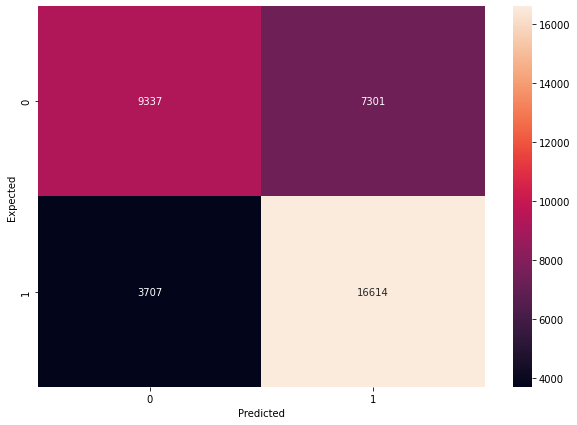

In [ ]:
classify(['UK', 'US'], svc_cl_uk_us, 'doc2vec_vector_lem')

Accuracy: 0.7097053491707027


(0.7097053491707027,
       predicted_region  ...                                               text
 0                   US  ...  [-0.01460434589534998, -0.06321698427200317, -...
 1                   UK  ...  [-0.0010253499494865537, -0.049059949815273285...
 2                   US  ...  [-0.0038967709988355637, -0.03364259749650955,...
 3                   UK  ...  [0.010926646180450916, 0.013701568357646465, 0...
 4                   US  ...  [0.040969688445329666, -0.06311841309070587, 0...
 ...                ...  ...                                                ...
 36954               UK  ...  [0.059037256985902786, 0.016488349065184593, -...
 36955               UK  ...  [0.0299278162419796, -0.007372890133410692, -0...
 36956               US  ...  [-0.0588916540145874, 0.08179319649934769, 0.0...
 36957               UK  ...  [0.023893484845757484, 0.005237833131104708, -...
 36958               US  ...  [0.008772323839366436, 0.009982501156628132, 0...
 
 [36959 rows x 3 

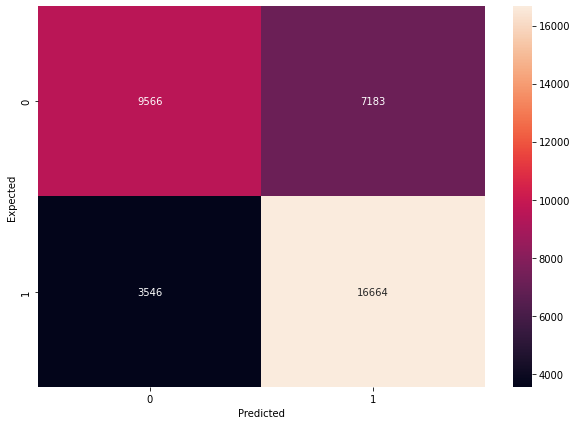

In [ ]:
classify(['UK', 'US'], svc_cl_uk_us, 'doc2vec_vector')

## Australia - US
RandomForestClassifier
LogisticRegression
KNeighborsClassifier
LinearSVC


**************************
Vector Space: word2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.6788083323635518
LogisticRegression(max_iter=30000)
Accuracy: 0.6610031420924007
KNeighborsClassifier()
Accuracy: 0.6589375072733621
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.6615559176073548

**************************
Vector Space: word2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.6791574537414174
LogisticRegression(max_iter=30000)
Accuracy: 0.6732805772140114
KNeighborsClassifier()
Accuracy: 0.6547480507389736
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.669585709298266

**************************
Vector Space: doc2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.6331607122076108
LogisticRegression(max_iter=30000)
Accuracy: 0.6464855114628185
KNeighborsClassifier()
Accuracy: 0.5715407890143139
LinearSVC()
Accuracy: 0.6480856511113697

**************************
Vector Space: doc2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.6422378680321191
LogisticRegression(max_iter=30000)
Accuracy: 0.6442162225066915
KNeighborsClassifier()
Accuracy: 0.5730827417665542
LinearSVC()
Accuracy: 0.6471546607703945


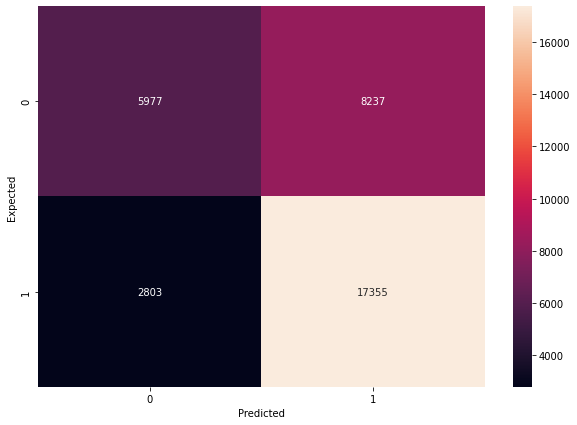

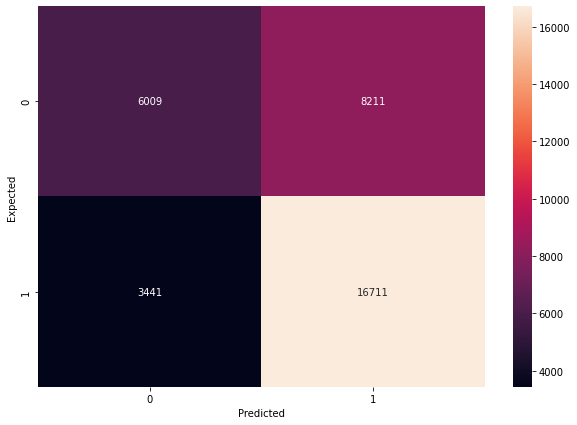

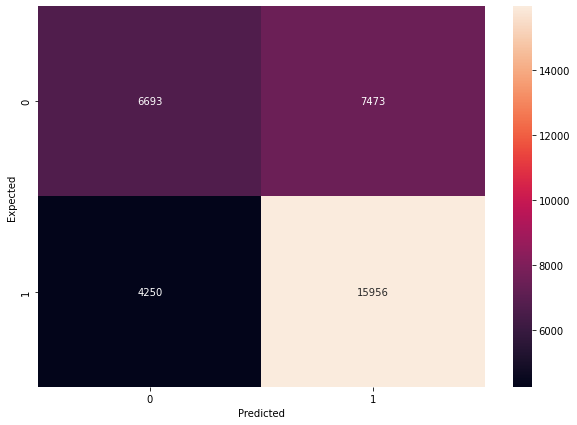

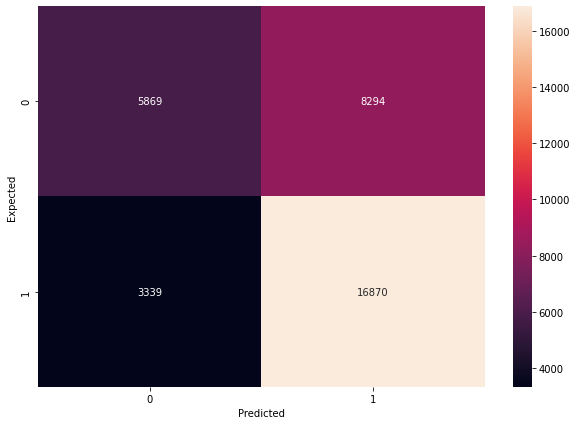

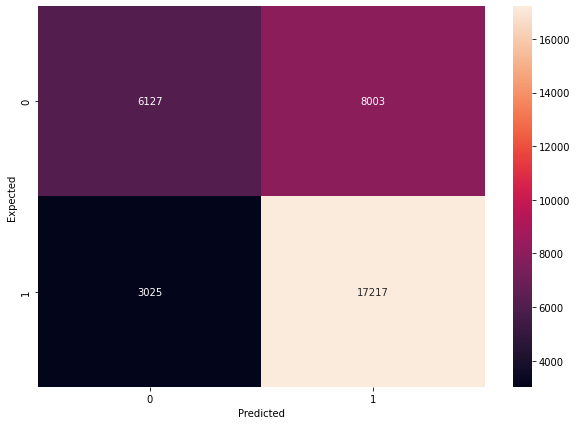

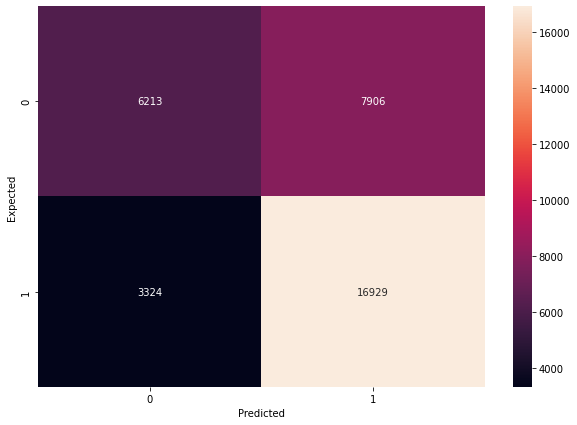

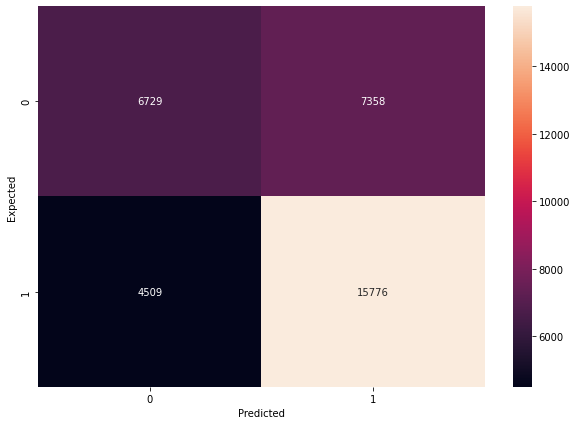

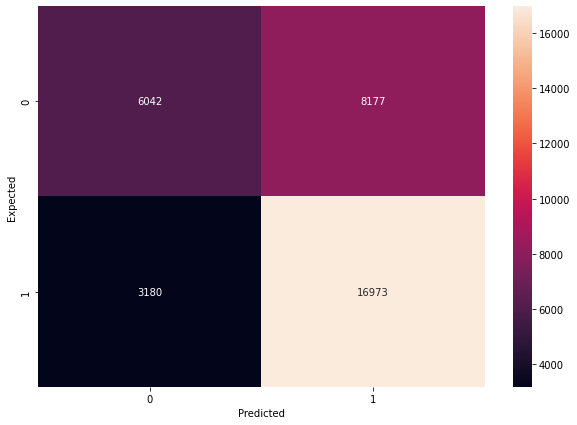

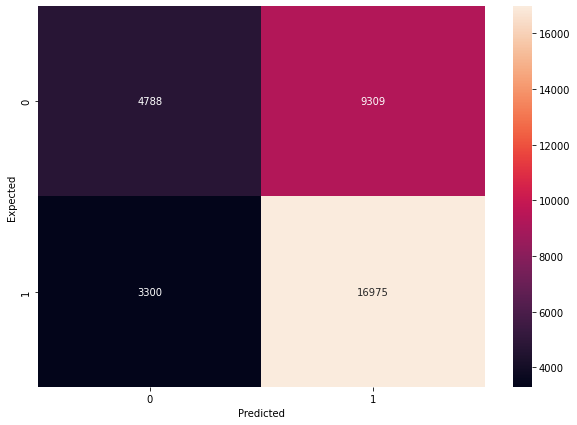

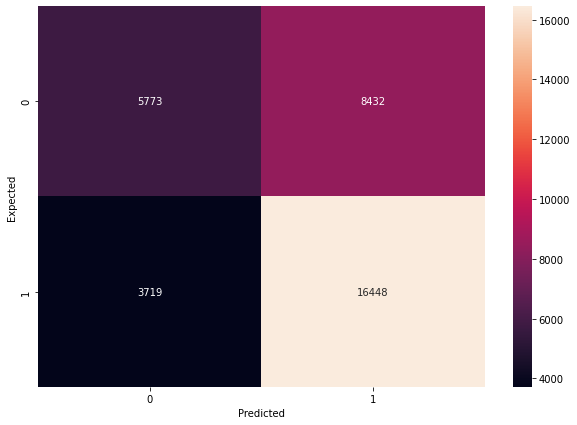

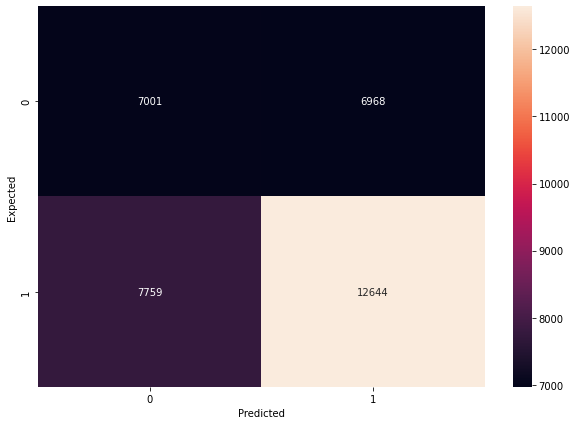

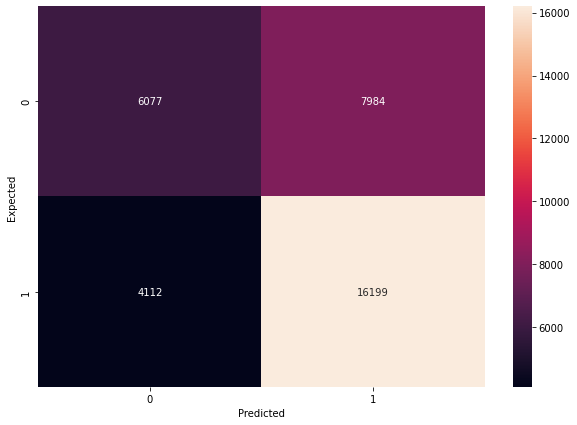

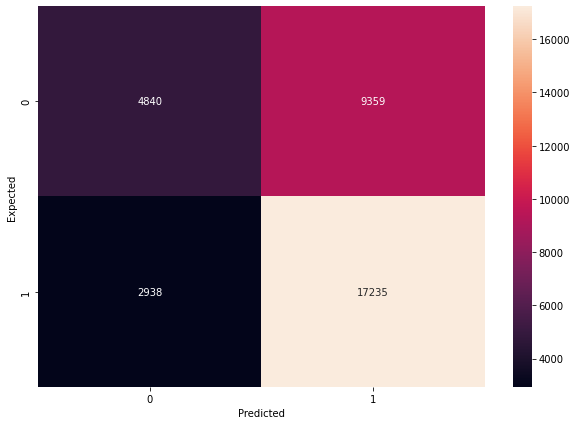

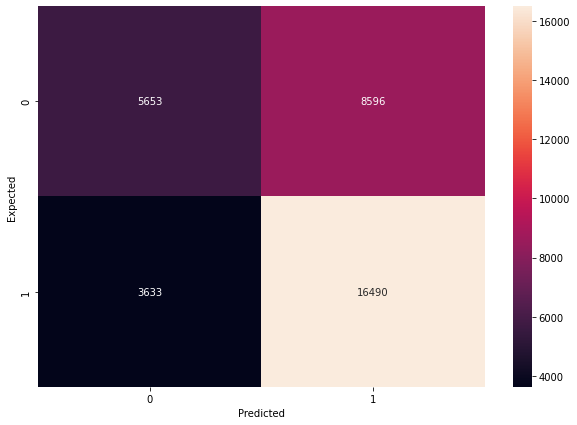

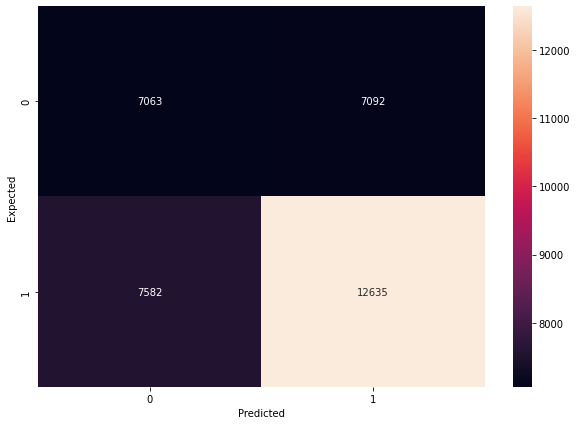

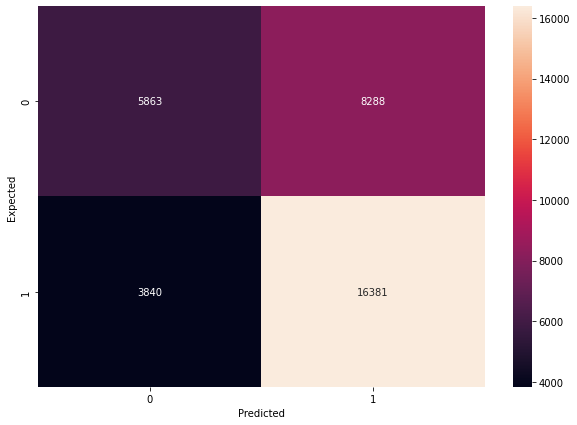

In [ ]:
test_different_vectors_and_classifiers(['Australia', 'US'])

Accuracy: 0.6811939951123007


(0.6811939951123007,
       predicted_region  ...                                               text
 0                   US  ...  [-0.317523796207992, -0.11127511636828477, 0.6...
 1                   US  ...  [0.22989519011229276, 0.06977794781327247, 0.3...
 2                   US  ...  [0.0033704105764627455, 0.36029669595882297, 0...
 3                   US  ...  [0.13791440992836693, 0.44115399245760945, 0.6...
 4                   US  ...  [-0.7975239963891606, 0.06634709847470124, 0.1...
 ...                ...  ...                                                ...
 34367               US  ...  [-0.43135756015015597, -0.1860626403411681, 0....
 34368        Australia  ...  [-0.2748149051592918, -0.016937492229044438, 0...
 34369               US  ...  [0.011634774182153784, 0.3651924774698589, 0.8...
 34370               US  ...  [0.07608305206761146, -0.23544635258328456, 0....
 34371               US  ...  [-0.5028499893438166, -0.21788366712056673, 0....
 
 [34372 rows x 3 

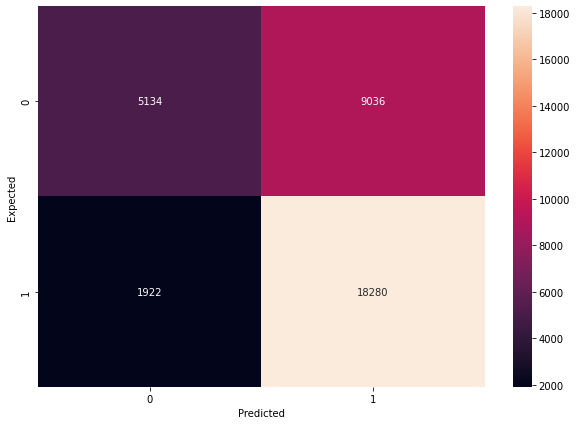

In [ ]:
svc_cl_au_us = svm.SVC()
classify(['Australia', 'US'], svc_cl_au_us, 'word2vec_vector_lem')

Accuracy: 0.6903584312812755


(0.6903584312812755,
       predicted_region  ...                                               text
 0                   US  ...  [-0.09851002308229605, -0.7973459968220494, 0....
 1                   US  ...  [0.12350578152556689, -0.7632098262054989, 0.5...
 2                   US  ...  [-0.2724783779552672, -0.3393083371967077, 0.5...
 3                   US  ...  [0.5942560434341431, -1.4828908443450928, 0.65...
 4                   US  ...  [0.1562445203214884, -1.0528624905645847, 0.89...
 ...                ...  ...                                                ...
 34367               US  ...  [0.23662325302855328, -0.3251652501236934, 0.4...
 34368               US  ...  [-0.15004634857177734, -0.7503029108047485, 0....
 34369               US  ...  [-0.1749629510136751, -0.8242391537015255, 0.4...
 34370               US  ...  [0.39948274940252304, 0.03251451676090558, 0.5...
 34371               US  ...  [-0.18446652790797607, -1.0100529904843174, 0....
 
 [34372 rows x 3 

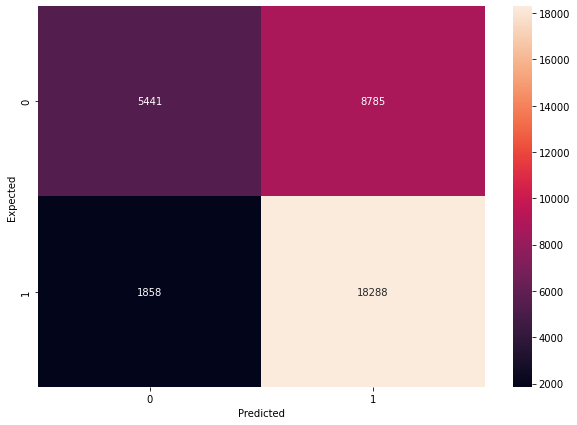

In [ ]:
classify(['Australia', 'US'], svc_cl_au_us, 'word2vec_vector')

Accuracy: 0.6681601303386477


(0.6681601303386477,
       predicted_region  ...                                               text
 0            Australia  ...  [0.010057506151497364, -0.05462413653731346, -...
 1            Australia  ...  [0.0465606264770031, 0.018681982532143593, -0....
 2                   US  ...  [0.01941513642668724, 0.010750124230980873, -0...
 3                   US  ...  [-0.0714317038655281, -0.04791191592812538, -0...
 4                   US  ...  [-0.03211308270692825, -0.17305634915828705, -...
 ...                ...  ...                                                ...
 34367               US  ...  [0.03716372326016426, 0.02862265519797802, -0....
 34368        Australia  ...  [0.03747572749853134, -0.064128577709198, 0.01...
 34369               US  ...  [-0.008448612876236439, -0.047105345875024796,...
 34370               US  ...  [-0.026852170005440712, -0.02390853501856327, ...
 34371        Australia  ...  [0.01260540820658207, -0.0047951191663742065, ...
 
 [34372 rows x 3 

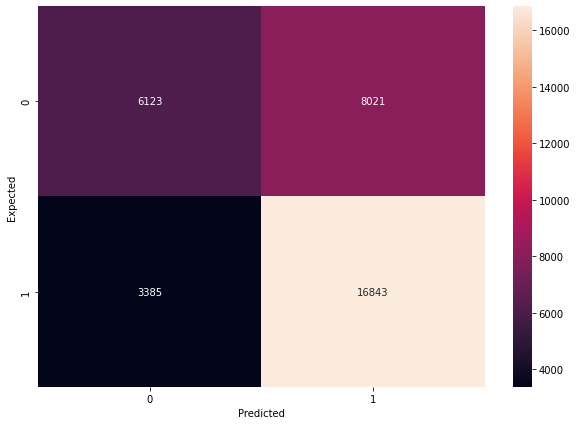

In [ ]:
classify(['Australia', 'US'], svc_cl_au_us, 'doc2vec_vector_lem')

Accuracy: 0.6749679972070289


(0.6749679972070289,
       predicted_region  ...                                               text
 0                   US  ...  [0.011576145887374878, -0.0053862412460148335,...
 1                   US  ...  [0.06499052047729492, -0.030074410140514374, -...
 2            Australia  ...  [0.0661490336060524, 0.019528813660144806, 0.0...
 3                   US  ...  [0.007087895181030035, -0.02966652624309063, 0...
 4            Australia  ...  [0.011616326868534088, 0.037593577057123184, 0...
 ...                ...  ...                                                ...
 34367               US  ...  [-0.023421596735715866, 0.010343685746192932, ...
 34368               US  ...  [0.008923648856580257, -0.0001410275581292808,...
 34369        Australia  ...  [0.021441424265503883, 0.05199038237333298, -0...
 34370               US  ...  [0.026987168937921524, -0.07996448129415512, 0...
 34371               US  ...  [-0.01337024848908186, -0.029494555667042732, ...
 
 [34372 rows x 3 

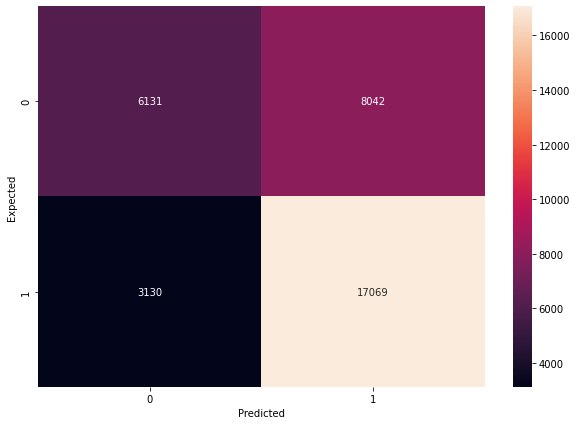

In [ ]:
classify(['Australia', 'US'], svc_cl_au_us, 'doc2vec_vector')

## Canada - US
RandomForestClassifier
LogisticRegression
KNeighborsClassifier
LinearSVC


**************************
Vector Space: word2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.6428049303052453
LogisticRegression(max_iter=30000)
Accuracy: 0.6168426889824313
KNeighborsClassifier()
Accuracy: 0.6139439921357094
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.6136163133617322

**************************
Vector Space: word2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.6390240213747385
LogisticRegression(max_iter=30000)
Accuracy: 0.6099110226098354
KNeighborsClassifier()
Accuracy: 0.6134650770045119
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.602223174451138

**************************
Vector Space: doc2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.6120787437299927
LogisticRegression(max_iter=30000)
Accuracy: 0.6333778640385148
KNeighborsClassifier()
Accuracy: 0.5662793335517858
LinearSVC()
Accuracy: 0.6346129609558138

**************************
Vector Space: doc2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.6127341012779473
LogisticRegression(max_iter=30000)
Accuracy: 0.6280341794167318
KNeighborsClassifier()
Accuracy: 0.5614901822398104
LinearSVC()
Accuracy: 0.6274544400473874


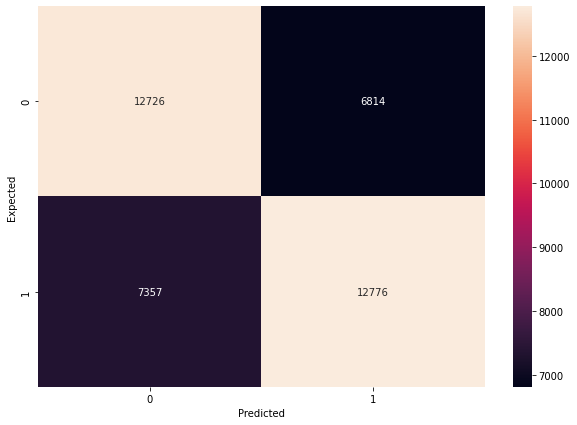

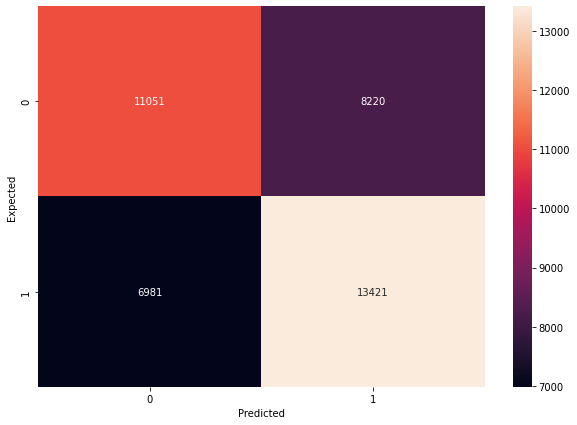

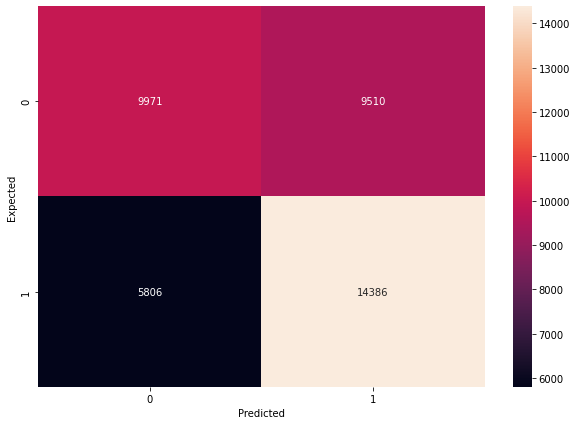

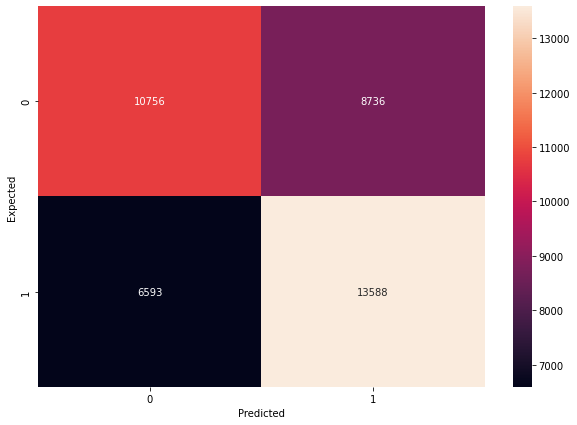

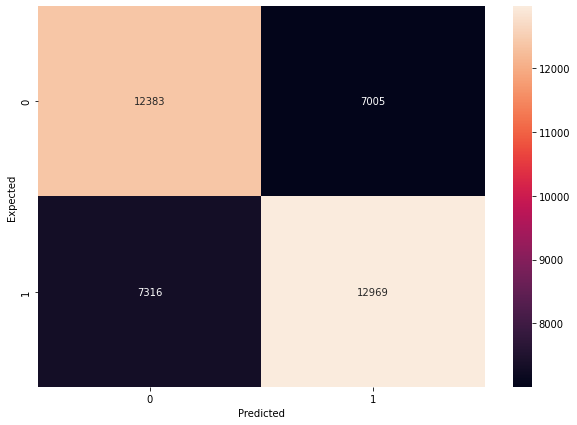

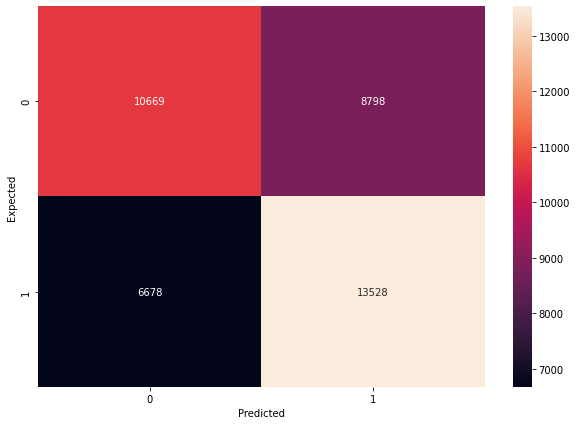

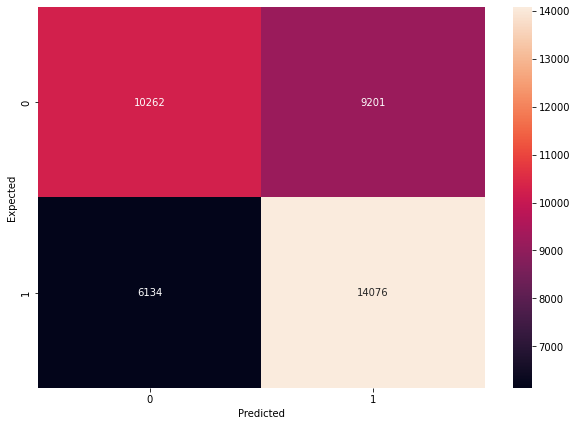

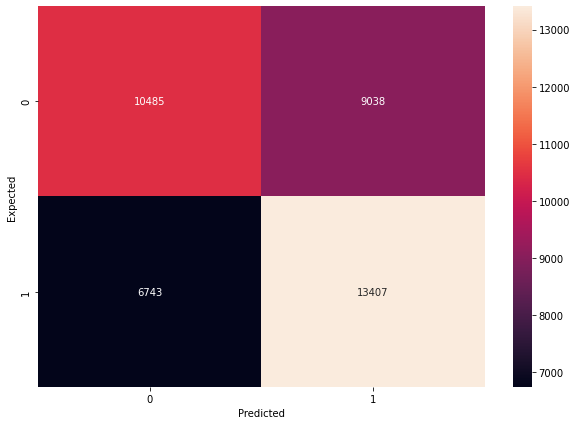

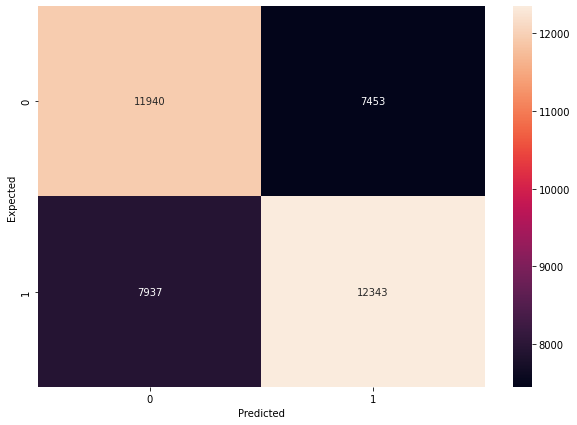

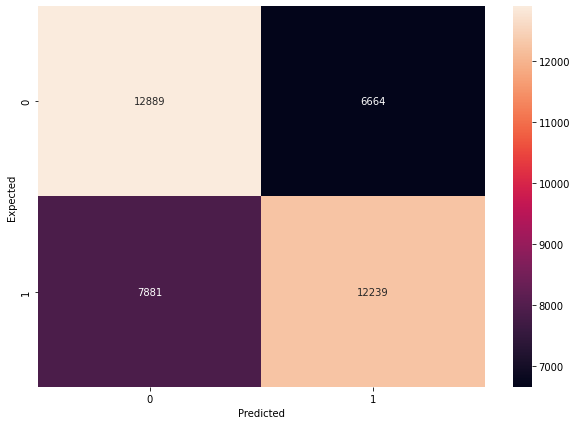

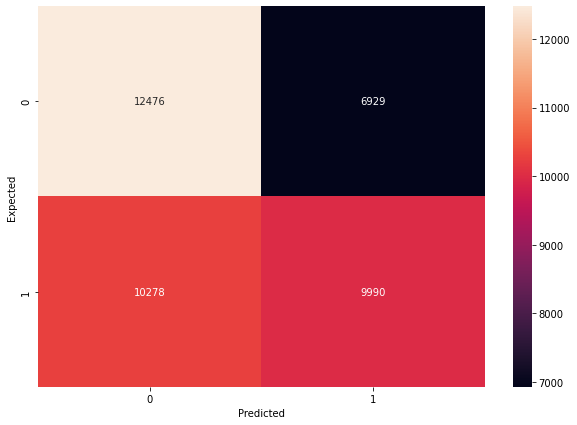

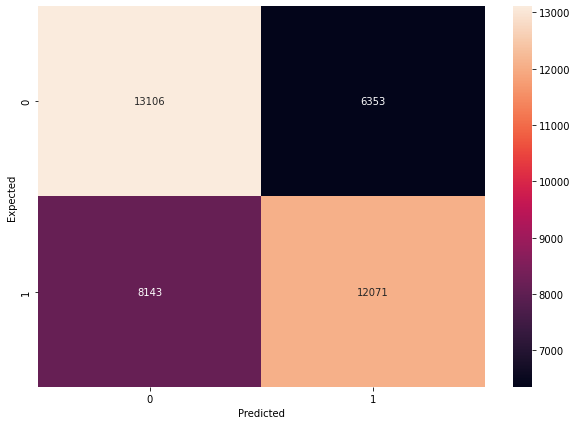

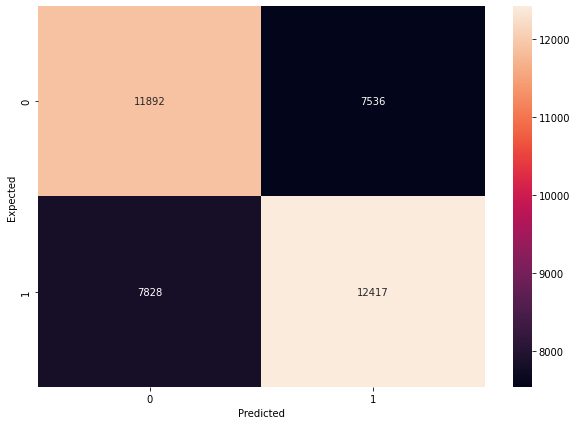

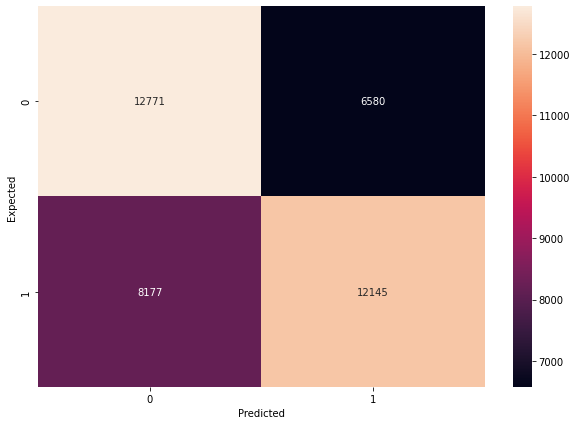

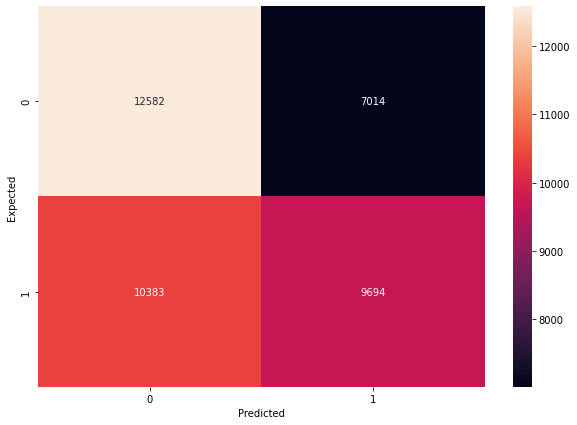

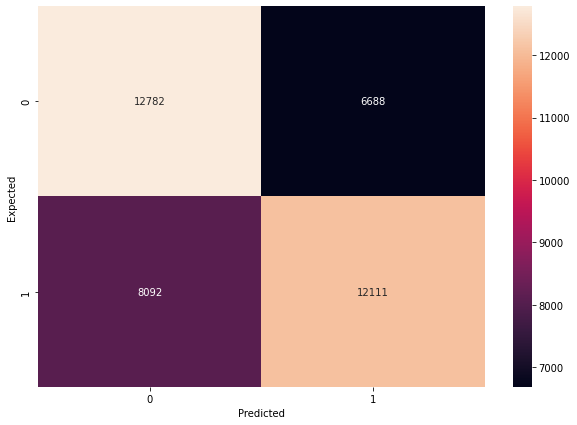

In [ ]:
test_different_vectors_and_classifiers(['Canada', 'US'])

Accuracy: 0.6486527361177628


(0.6486527361177628,
       predicted_region  ...                                               text
 0               Canada  ...  [-0.02589293431845449, -0.016953580436252412, ...
 1               Canada  ...  [0.32167983893305063, 0.35425757253542545, 0.6...
 2                   US  ...  [-0.2163127129996552, -0.1767243154029897, 0.5...
 3                   US  ...  [-0.15700094372566256, -0.14229721905929701, 0...
 4                   US  ...  [0.14330230864624566, 0.2540103174889317, 0.49...
 ...                ...  ...                                                ...
 39668               US  ...  [-0.3269269759907867, 0.10584264316342094, 0.7...
 39669               US  ...  [0.19202117731964047, -0.38010060050609434, 0....
 39670           Canada  ...  [-0.26061516627669334, -0.007301941514015198, ...
 39671               US  ...  [0.12482169442144887, -0.4774240216772471, 0.4...
 39672               US  ...  [-0.4284695042133854, -0.06904713365069606, 0....
 
 [39673 rows x 3 

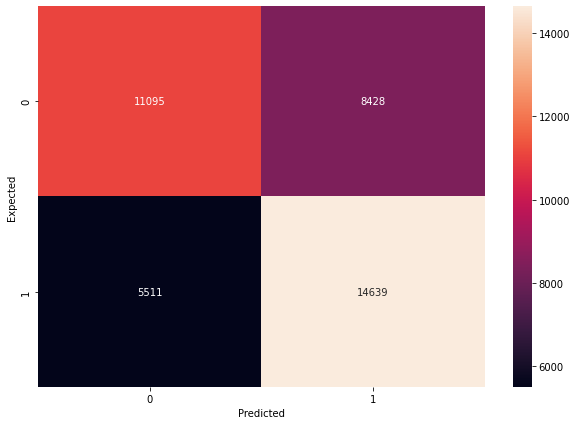

In [ ]:
svc_cl_us_ca = svm.SVC()
classify(['US', 'Canada'], svc_cl_us_ca, 'word2vec_vector_lem')

Accuracy: 0.6436367302699569


(0.6436367302699569,
       predicted_region  ...                                               text
 0               Canada  ...  [0.23023615404963493, -1.7369748260825872, 0.3...
 1                   US  ...  [-0.06665135448177656, 0.13206573128700255, 0....
 2               Canada  ...  [-0.0004857598105445504, -0.34270572662353516,...
 3               Canada  ...  [0.26611996324438797, -1.0802840410094512, 1.0...
 4                   US  ...  [-0.523408297166178, -0.6648856926704694, 0.30...
 ...                ...  ...                                                ...
 39668           Canada  ...  [0.15653252168558537, -1.0910014351014978, 0.6...
 39669           Canada  ...  [1.0271259519186886, 1.0092594913122328, 0.546...
 39670           Canada  ...  [0.013464550487697124, -1.4297479391098022, 0....
 39671               US  ...  [-0.045138851954386786, -1.0444005654694943, 0...
 39672               US  ...  [-0.2633000910282135, -0.998028039932251, 0.74...
 
 [39673 rows x 3 

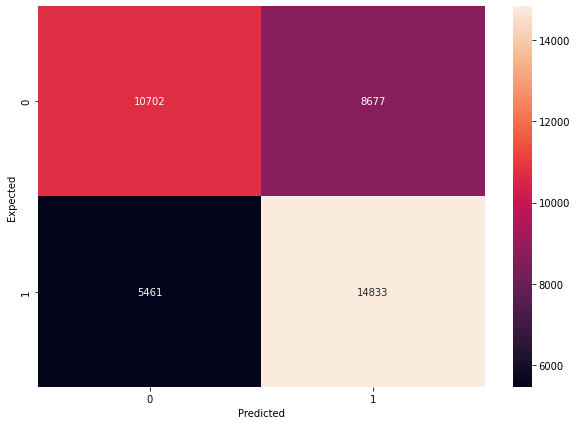

In [ ]:
svc_cl_us_ca = svm.SVC()
classify(['US', 'Canada'], svc_cl_us_ca, 'word2vec_vector')

Accuracy: 0.6546517782875003


(0.6546517782875003,
       predicted_region  ...                                               text
 0                   US  ...  [0.006023226771503687, -0.0052008056081831455,...
 1                   US  ...  [-0.013676400296390057, -0.027735022827982903,...
 2               Canada  ...  [0.012962918728590012, -0.07689040899276733, 0...
 3                   US  ...  [-0.017901422455906868, -0.1458381712436676, 0...
 4                   US  ...  [0.013400696218013763, -0.0757940262556076, -0...
 ...                ...  ...                                                ...
 39668           Canada  ...  [0.06460253149271011, -0.056970469653606415, -...
 39669               US  ...  [-0.02171279303729534, -0.00045861583203077316...
 39670           Canada  ...  [-0.026849273592233658, -0.017121750861406326,...
 39671           Canada  ...  [0.008618240244686604, 0.04341030493378639, -0...
 39672           Canada  ...  [-0.011327848769724369, -0.04663562402129173, ...
 
 [39673 rows x 3 

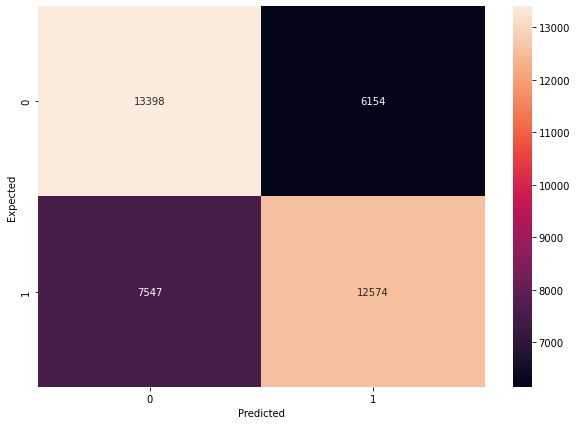

In [ ]:
classify(['US', 'Canada'], svc_cl_us_ca, 'doc2vec_vector_lem')

Accuracy: 0.6531394147152976


(0.6531394147152976,
       predicted_region  ...                                               text
 0               Canada  ...  [-0.15720513463020325, 0.015548373572528362, 0...
 1               Canada  ...  [0.027403339743614197, -0.04119914397597313, -...
 2               Canada  ...  [0.03290504217147827, -0.00831529963761568, -0...
 3                   US  ...  [0.07087839394807816, -0.02968411147594452, 0....
 4               Canada  ...  [-0.04173659160733223, 0.012741873040795326, 0...
 ...                ...  ...                                                ...
 39668           Canada  ...  [-0.01835552416741848, -0.0031081608030945063,...
 39669               US  ...  [0.06708748638629913, -0.024348249658942223, -...
 39670           Canada  ...  [0.029628679156303406, 0.015822377055883408, -...
 39671               US  ...  [0.009268980473279953, 0.0013185302959755063, ...
 39672           Canada  ...  [-0.03987018018960953, -0.03210553899407387, -...
 
 [39673 rows x 3 

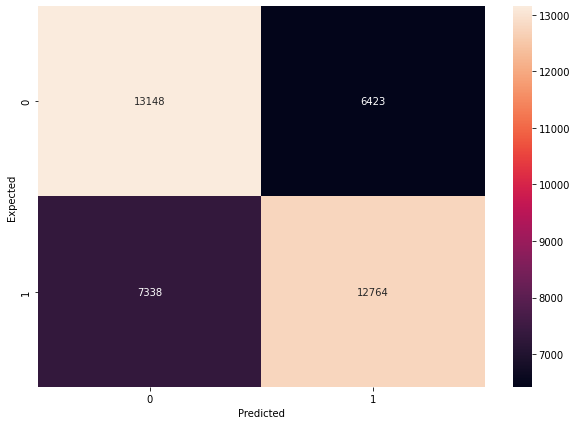

In [ ]:
classify(['US', 'Canada'], svc_cl_us_ca, 'doc2vec_vector')

## Australia - Canada
RandomForestClassifier
LogisticRegression
KNeighborsClassifier
LinearSVC


**************************
Vector Space: word2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.6849893035417162
LogisticRegression(max_iter=30000)
Accuracy: 0.6624078916092228
KNeighborsClassifier()
Accuracy: 0.6548906584264321
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.6666864749227478

**************************
Vector Space: word2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.682909436653197
LogisticRegression(max_iter=30000)
Accuracy: 0.6550392203470407
KNeighborsClassifier()
Accuracy: 0.6578024720703589
LinearSVC()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.6528405039220347

**************************
Vector Space: doc2vec_vector_lem
Classifiers:
RandomForestClassifier()
Accuracy: 0.6374792013311148
LogisticRegression(max_iter=30000)
Accuracy: 0.6472545757071547
KNeighborsClassifier()
Accuracy: 0.5910981697171381
LinearSVC()
Accuracy: 0.6461849298787735

**************************
Vector Space: doc2vec_vector
Classifiers:
RandomForestClassifier()
Accuracy: 0.6366472545757071
LogisticRegression(max_iter=30000)
Accuracy: 0.6456798193487046
KNeighborsClassifier()
Accuracy: 0.5856013786546233
LinearSVC()
Accuracy: 0.646036367958165


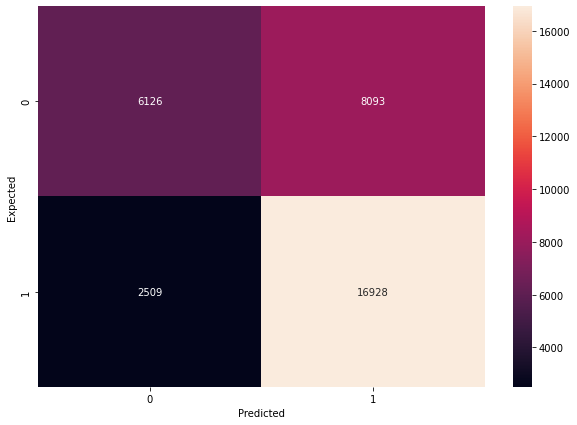

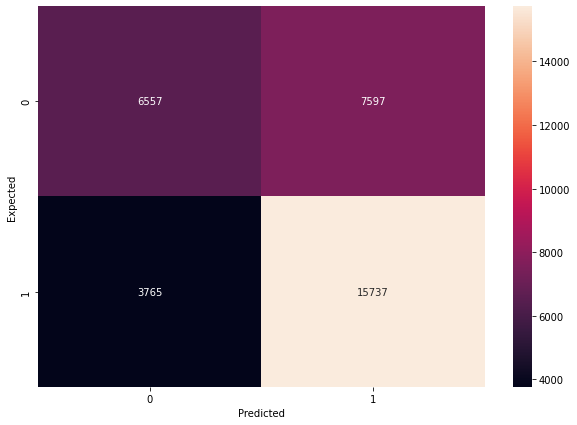

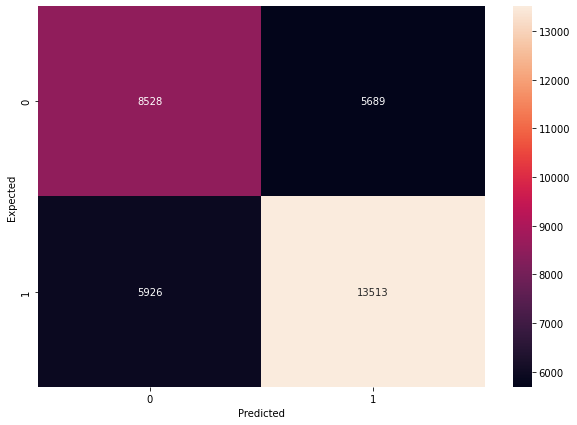

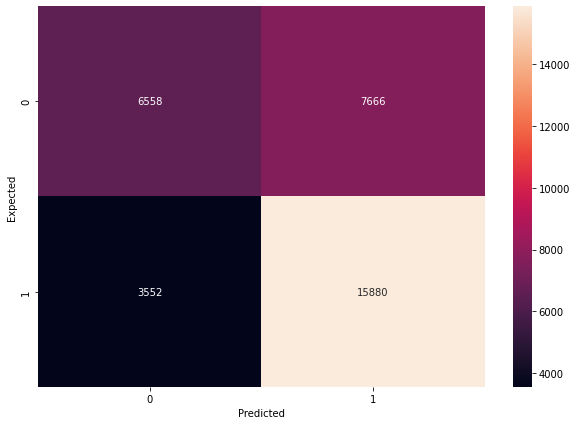

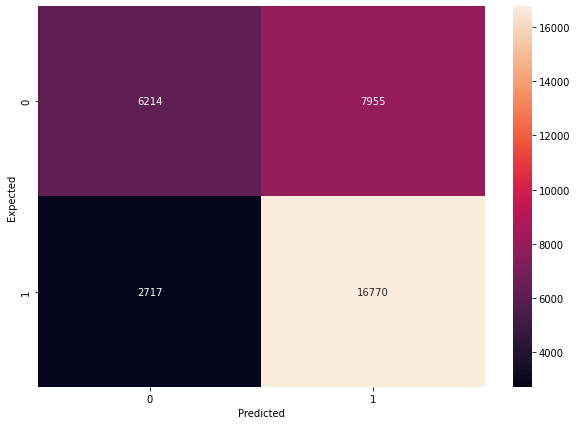

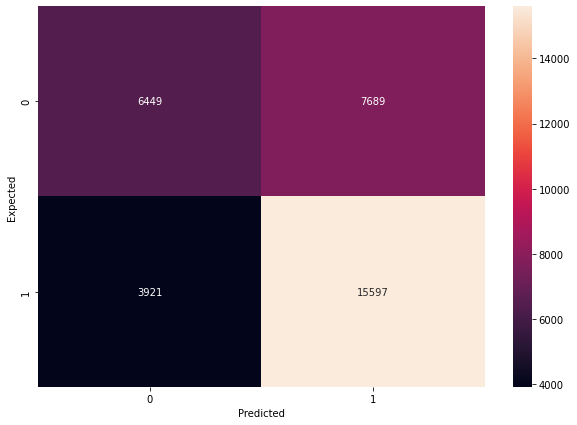

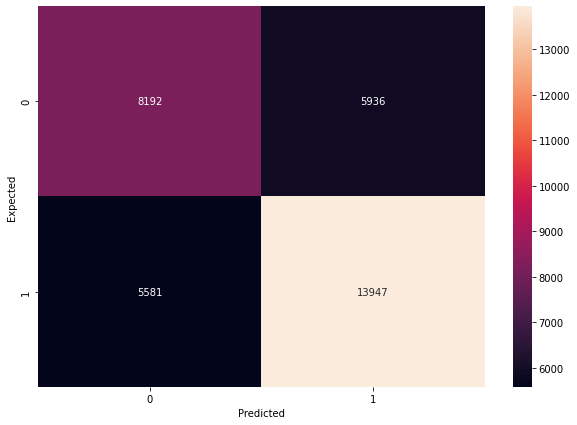

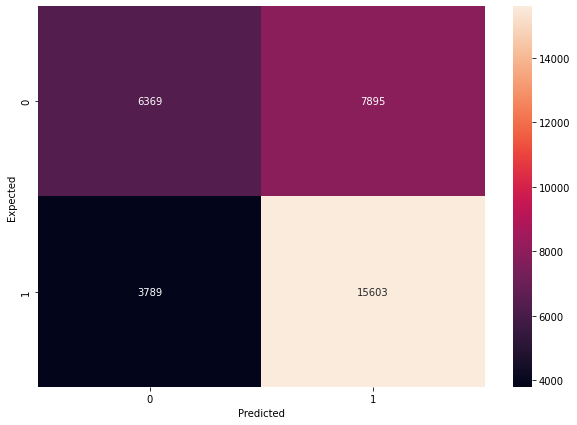

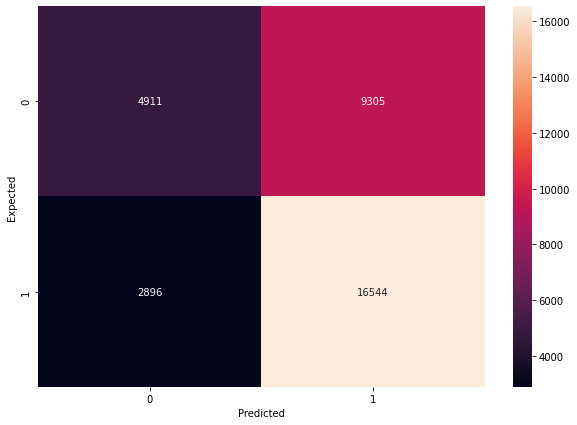

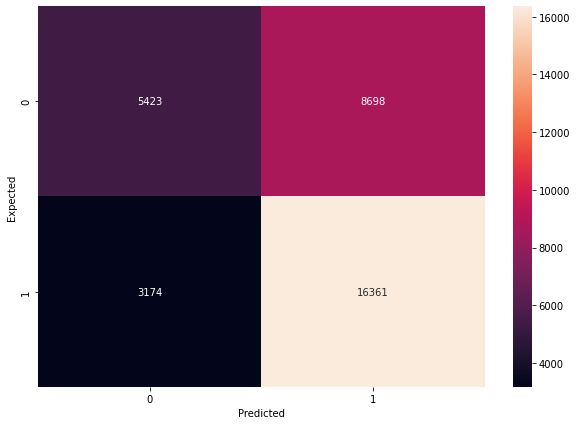

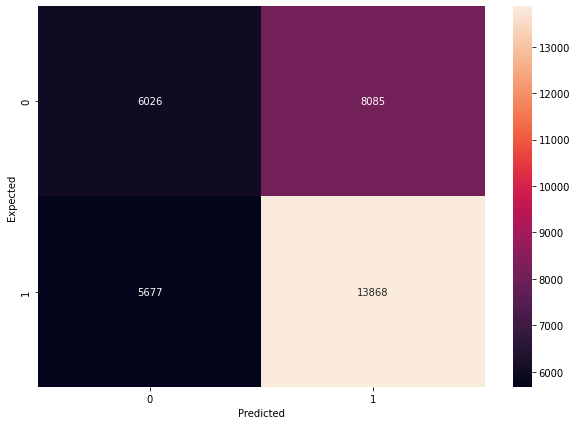

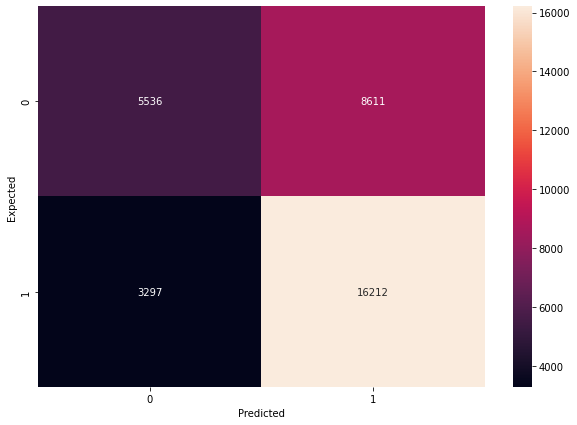

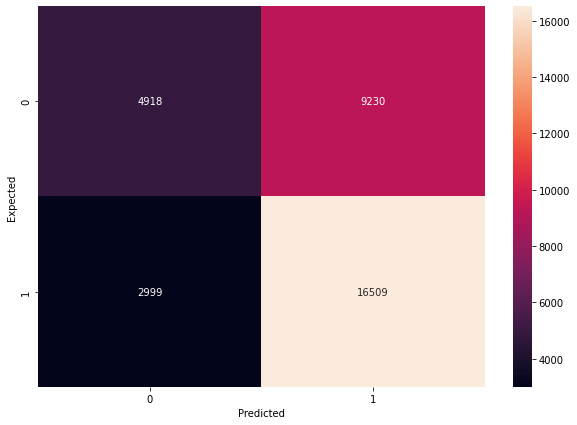

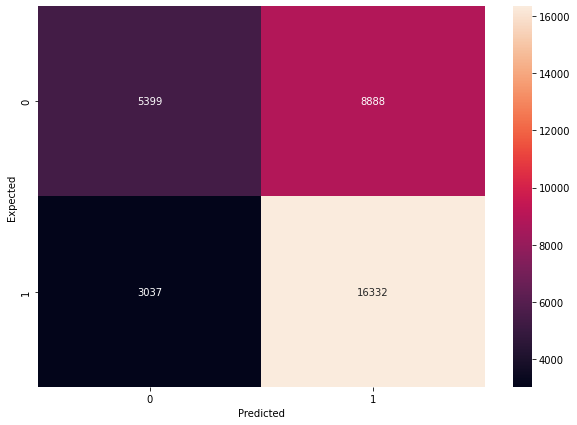

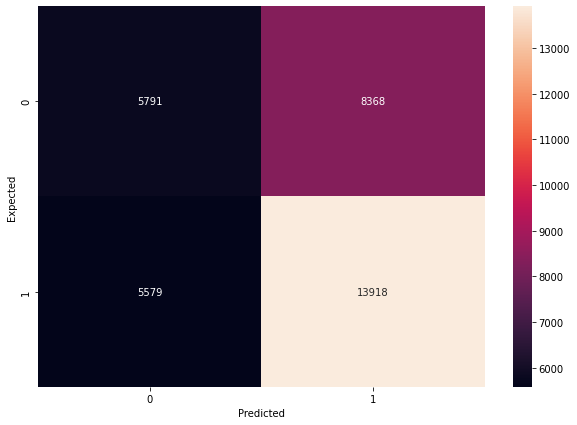

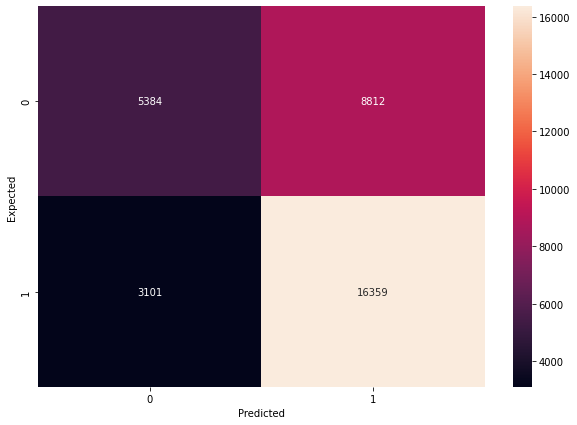

In [ ]:
test_different_vectors_and_classifiers(['Australia', 'Canada'])

Accuracy: 0.6934276206322796


(0.6934276206322796,
       predicted_region  ...                                               text
 0               Canada  ...  [-0.02582735816637675, -0.2710307128727436, 0....
 1            Australia  ...  [-0.06750560645014048, 0.10266597612815745, 0....
 2            Australia  ...  [0.22991917758352226, 0.7148855117460092, 0.72...
 3            Australia  ...  [0.05379511087778069, 0.09145931367363248, 0.8...
 4               Canada  ...  [-0.02198837078952541, 0.5419524586449067, 0.7...
 ...                ...  ...                                                ...
 33651           Canada  ...  [-0.04369289997965097, -0.04268460681661963, 0...
 33652           Canada  ...  [-0.42934406256641855, 0.09711320207200268, 0....
 33653           Canada  ...  [0.35109591437503695, 0.018042226269608365, 0....
 33654        Australia  ...  [-0.08922391683445312, -0.28323266848456113, 0...
 33655           Canada  ...  [-0.08673771820031106, 0.2622146011912264, 0.4...
 
 [33656 rows x 3 

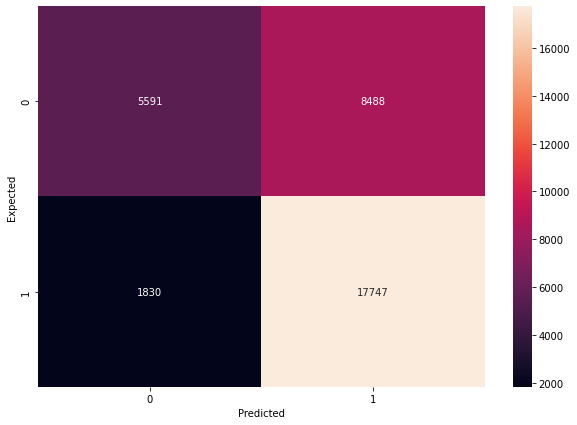

In [ ]:
svc_cl_au_ca = svm.SVC()
classify(['Australia', 'Canada'], svc_cl_au_ca, 'word2vec_vector_lem')

Accuracy: 0.6942892797718089


(0.6942892797718089,
       predicted_region  ...                                               text
 0            Australia  ...  [-0.031456532370713025, -0.6237747665856861, 0...
 1            Australia  ...  [-0.03444782004225999, -0.8992412346178753, 0....
 2               Canada  ...  [-0.44568111188709736, -0.9078946895897388, 0....
 3            Australia  ...  [-0.2432196244996573, -0.4907449456730059, 0.6...
 4               Canada  ...  [-0.34875733653704327, -0.01785881817340851, 0...
 ...                ...  ...                                                ...
 33651           Canada  ...  [-0.2861481109126048, -0.5122059445658868, 1.0...
 33652           Canada  ...  [0.10533342137932777, -0.5036041844974865, 0.3...
 33653           Canada  ...  [-0.28562013844543316, -0.9937469335867369, 0....
 33654           Canada  ...  [0.49239093076903373, -0.19990556652192026, 0....
 33655           Canada  ...  [-0.633826732635498, -1.698011040687561, 0.831...
 
 [33656 rows x 3 

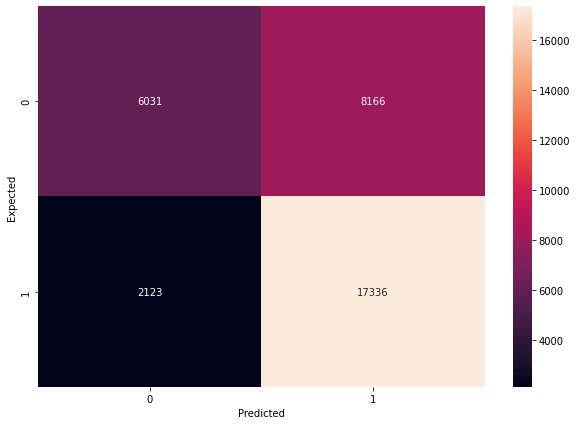

In [ ]:
classify(['Australia', 'Canada'], svc_cl_au_ca, 'word2vec_vector')

Accuracy: 0.6786011409555502


(0.6786011409555502,
       predicted_region  ...                                               text
 0               Canada  ...  [0.031314413994550705, -0.04860636964440346, -...
 1               Canada  ...  [0.031249288469552994, -0.0029683862812817097,...
 2               Canada  ...  [0.07916735112667084, -0.01196378469467163, 0....
 3            Australia  ...  [-0.06429696083068848, -0.06815645843744278, 0...
 4               Canada  ...  [-0.047842320054769516, -0.014043932780623436,...
 ...                ...  ...                                                ...
 33651        Australia  ...  [0.049418605864048004, -0.06998953223228455, -...
 33652        Australia  ...  [-0.022147677838802338, -0.011889775283634663,...
 33653        Australia  ...  [0.014264420606195927, -0.014575754292309284, ...
 33654           Canada  ...  [0.003934235777705908, 0.00795187707990408, -0...
 33655           Canada  ...  [0.04674537107348442, -0.089536152780056, 0.03...
 
 [33656 rows x 3 

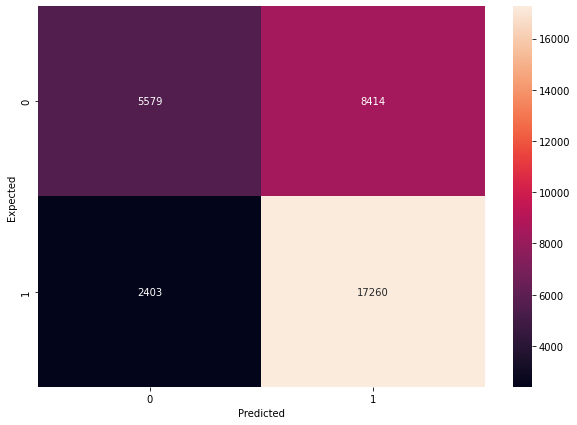

In [ ]:
classify(['Australia', 'Canada'], svc_cl_au_ca, 'doc2vec_vector_lem')

Accuracy: 0.6742928452579035


(0.6742928452579035,
       predicted_region  ...                                               text
 0               Canada  ...  [0.04253441467881203, -0.04102455824613571, -0...
 1               Canada  ...  [0.027587665244936943, 0.007372275460511446, 0...
 2               Canada  ...  [0.002254112623631954, 0.018753506243228912, -...
 3               Canada  ...  [0.07339738309383392, -0.03546169027686119, 0....
 4               Canada  ...  [0.0014121592976152897, 0.03630789369344711, -...
 ...                ...  ...                                                ...
 33651        Australia  ...  [-0.03763337805867195, -0.015627529472112656, ...
 33652           Canada  ...  [0.06083017960190773, -0.07047955691814423, -0...
 33653           Canada  ...  [0.008644009940326214, 0.008073272183537483, 0...
 33654           Canada  ...  [-0.007916503585875034, -0.04920478165149689, ...
 33655           Canada  ...  [0.03289776295423508, 0.015191209502518177, -0...
 
 [33656 rows x 3 

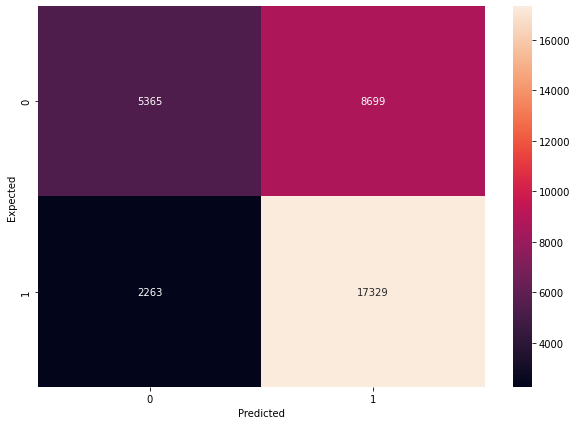

In [ ]:
classify(['Australia', 'Canada'], svc_cl_au_ca, 'doc2vec_vector')